<a href="https://colab.research.google.com/github/khaqan-ashraf/msds19019_COVID19_DLSpring2020/blob/master/covid19_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
DATADIR = '/content/gdrive/My Drive/Assignment 5 Dataset'

In [4]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(DATADIR + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(DATADIR + '/test', transform=test_transforms)
validation_data = datasets.ImageFolder(DATADIR + '/validation', transform=test_transforms)


#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=8, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

In [6]:
inputs, classes = next(iter(trainloader))
inputs.shape, classes.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


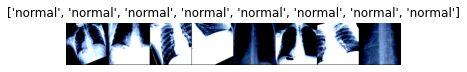

In [7]:
show_databatch(inputs, classes)

In [0]:
def train(net, epochs, trainloader, critarion, optimizer):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)

    print('Device: ', device)

    net.train()


    confusion_metrices = dict()
    for epoch in range(epochs):
        train_predictions, train_labels = list(), list()
        loss_curve = list()
        accuracy_curve = list()
        for i, data in tqdm(enumerate(trainloader)):

          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = net(inputs)
          loss = critarion(outputs, labels)
          loss.backward()
          optimizer.step()

          _, predicted = torch.max(outputs.data, 1)

          train_predictions.extend(list(labels.numpy()))
          train_labels.extend(list(predicted.numpy()))

          total = labels.size(0)
          correct = (predicted==labels).sum().item()

          accuracy_curve.append(correct/total)
          loss_curve.append(loss.item())

          print("\tLoss:", loss.item(), '\tAccuracy:', correct/total)

        confusion_metrices[epoch] = confusion_matrix(train_labels, train_predictions)

    return loss_curve, accuracy_curve

In [0]:
def predict(net, testloader, critarion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    with torch.no_grad():
        test_predictions, test_labels = list(), list()
        loss_curve = list()
        accuracy_curve = list()
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = critarion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            test_predictions.extend(list(predicted.numpy()))
            test_labels.extend(list(labels.numpy()))

            total = labels.size(0)
            correct = (predicted==labels).sum().item()

            accuracy_curve.append(correct/total)
            loss_curve.append(loss.item())

            print('\tLoss: ', loss.item())
            print('\tAccuracy: ', correct/total)


    return loss_curve, accuracy_curve, confusion_matrix(test_labels, test_predictions)

# Task 1

In [0]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)
print(vgg16)
print(resnet18)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
# Roll no. MSDS19019 => 19*10+100 = 290


vgg_num_features = vgg16.classifier[0].in_features
resnet_num_features = resnet18.fc.in_features
vgg_fc = [
    nn.Linear(vgg_num_features, 290), 
    nn.ReLU(), 
    nn.Linear(290, len(train_data.classes))
]

resnet_fc = [
    nn.Linear(resnet_num_features, 290), 
    nn.ReLU(), 
    nn.Linear(290, len(train_data.classes))         
]


vgg_fc, resnet_fc

([Linear(in_features=25088, out_features=290, bias=True),
  ReLU(),
  Linear(in_features=290, out_features=2, bias=True)],
 [Linear(in_features=512, out_features=290, bias=True),
  ReLU(),
  Linear(in_features=290, out_features=2, bias=True)])

In [0]:
vgg16.classifier = nn.Sequential(*vgg_fc)
resnet18.fc = nn.Sequential(*resnet_fc)

In [0]:
for param in vgg16.parameters():
    param.requires_grad = False

for param in resnet18.parameters():
    param.requires_grad = False


In [0]:
for param in vgg16.classifier.parameters():
    param.requires_grad = True

for param in resnet18.fc.parameters():
    param.requires_grad = True

In [0]:
for param in vgg16.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True


In [0]:
epochs = 1
critarion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), 0.01, 0.9)
loss_curve, accuracy_curve = train(vgg16, epochs, trainloader, critarion, optimizer)

0it [00:00, ?it/s]

Device:  cpu


1it [00:06,  6.96s/it]

	Loss: 0.7264480590820312 	Accuracy: 0.25


2it [00:14,  7.10s/it]

	Loss: 0.014358819462358952 	Accuracy: 1.0


3it [00:21,  7.07s/it]

	Loss: 0.0009268821449950337 	Accuracy: 1.0


4it [00:32,  8.40s/it]

	Loss: 0.0022533333394676447 	Accuracy: 1.0


5it [00:40,  8.22s/it]

	Loss: 9.566316293785349e-06 	Accuracy: 1.0


6it [00:47,  7.90s/it]

	Loss: 9.685717259344528e-07 	Accuracy: 1.0


7it [00:54,  7.57s/it]

	Loss: 1.0430808572436945e-07 	Accuracy: 1.0


8it [01:01,  7.36s/it]

	Loss: 7.00352870808274e-07 	Accuracy: 1.0


9it [01:08,  7.31s/it]

	Loss: 0.0 	Accuracy: 1.0


10it [01:15,  7.20s/it]

	Loss: 0.0 	Accuracy: 1.0


11it [01:22,  7.09s/it]

	Loss: 0.0 	Accuracy: 1.0


12it [01:29,  7.20s/it]

	Loss: 0.0 	Accuracy: 1.0


13it [01:37,  7.27s/it]

	Loss: 0.0 	Accuracy: 1.0


KeyboardInterrupt: ignored

In [0]:
torch.save(vgg16.state_dict(), '/content/gdrive/My Drive/vgg16_FC_Only.pth')

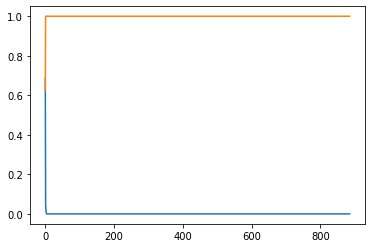

In [0]:
plt.plot(range(len(loss_curve)), loss_curve)
plt.plot(range(len(accuracy_curve)), accuracy_curve)

In [0]:
# train VGG16 with learning rate 0.001
epochs = 1
critarion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), 0.001, 0.9)
loss_curve, accuracy_curve = train(vgg16, epochs, trainloader, critarion, optimizer)

In [0]:
torch.save(vgg16.state_dict(), '/content/gdrive/My Drive/vgg16_FC_Only_0001.pth')

In [0]:
plt.plot(range(len(loss_curve)), loss_curve)
plt.plot(range(len(accuracy_curve)), accuracy_curve)

In [0]:
# train resnet18 with learning rate 0.01
epochs = 1
critarion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), 0.01, 0.9)
loss_curve, accuracy_curve = train(resnet18, epochs, trainloader, critarion, optimizer)


0it [00:00, ?it/s]

Device:  cpu



1it [00:03,  3.42s/it]

	Loss: 0.8953098058700562 	Accuracy: 0.0



2it [00:06,  3.42s/it]

	Loss: 0.42586615681648254 	Accuracy: 1.0



3it [00:10,  3.41s/it]

	Loss: 0.11942559480667114 	Accuracy: 1.0



4it [00:14,  3.55s/it]

	Loss: 0.029195083305239677 	Accuracy: 1.0



5it [00:17,  3.48s/it]

	Loss: 0.007033603265881538 	Accuracy: 1.0



6it [00:20,  3.47s/it]

	Loss: 0.0018915310502052307 	Accuracy: 1.0



7it [00:24,  3.49s/it]

	Loss: 0.00043434271356090903 	Accuracy: 1.0



8it [00:29,  3.82s/it]

	Loss: 0.0008043500129133463 	Accuracy: 1.0



9it [00:32,  3.86s/it]

	Loss: 6.8537839979399e-05 	Accuracy: 1.0



10it [00:36,  3.78s/it]

	Loss: 1.107146636059042e-05 	Accuracy: 1.0



11it [00:40,  3.69s/it]

	Loss: 8.314748811244499e-06 	Accuracy: 1.0



12it [00:43,  3.71s/it]

	Loss: 2.9355171591305407e-06 	Accuracy: 1.0



13it [00:47,  3.62s/it]

	Loss: 8.791676577857288e-07 	Accuracy: 1.0



14it [00:50,  3.53s/it]

	Loss: 8.195625582629873e-07 	Accuracy: 1.0



15it [00:53,  3.39s/it]

	Loss: 3.1292415769712534e-07 	Accuracy: 1.0



16it [00:57,  3.44s/it]

	Loss: 1.0430811414607888e-07 	Accuracy: 1.0



17it [01:00,  3.39s/it]

	Loss: 1.9371503867660067e-07 	Accuracy: 1.0



18it [01:04,  3.60s/it]

	Loss: 4.470348002882929e-08 	Accuracy: 1.0



19it [01:07,  3.46s/it]

	Loss: 1.639126594454865e-07 	Accuracy: 1.0



20it [01:10,  3.33s/it]

	Loss: 0.0 	Accuracy: 1.0



21it [01:16,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0



22it [01:20,  3.93s/it]

	Loss: 0.0 	Accuracy: 1.0



23it [01:23,  3.79s/it]

	Loss: 0.0 	Accuracy: 1.0



24it [01:28,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0



25it [01:32,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0



26it [01:36,  3.96s/it]

	Loss: 0.0 	Accuracy: 1.0



27it [01:39,  3.81s/it]

	Loss: 0.0 	Accuracy: 1.0



28it [01:43,  3.74s/it]

	Loss: 2.8312175004430173e-07 	Accuracy: 1.0



29it [01:47,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



30it [01:50,  3.74s/it]

	Loss: 0.0 	Accuracy: 1.0



31it [01:54,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



32it [01:57,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



33it [02:00,  3.45s/it]

	Loss: 0.0 	Accuracy: 1.0



34it [02:04,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



35it [02:07,  3.51s/it]

	Loss: 0.0 	Accuracy: 1.0



36it [02:11,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



37it [02:21,  5.43s/it]

	Loss: 0.0 	Accuracy: 1.0



38it [02:25,  4.99s/it]

	Loss: 0.0 	Accuracy: 1.0



39it [02:28,  4.53s/it]

	Loss: 0.0 	Accuracy: 1.0



40it [02:32,  4.17s/it]

	Loss: 0.0 	Accuracy: 1.0



41it [02:35,  4.00s/it]

	Loss: 0.0 	Accuracy: 1.0



42it [02:39,  3.94s/it]

	Loss: 0.0 	Accuracy: 1.0



43it [02:43,  3.99s/it]

	Loss: 0.0 	Accuracy: 1.0



44it [02:48,  4.27s/it]

	Loss: 0.0 	Accuracy: 1.0



45it [02:52,  4.09s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



46it [02:55,  3.88s/it]

	Loss: 0.0 	Accuracy: 1.0



47it [02:59,  3.79s/it]

	Loss: 0.0 	Accuracy: 1.0



48it [03:02,  3.76s/it]

	Loss: 0.0 	Accuracy: 1.0



49it [03:06,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



50it [03:09,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



51it [03:13,  3.60s/it]

	Loss: 0.0 	Accuracy: 1.0



52it [03:17,  3.89s/it]

	Loss: 0.0 	Accuracy: 1.0



53it [03:21,  3.74s/it]

	Loss: 0.0 	Accuracy: 1.0



54it [03:25,  3.85s/it]

	Loss: 0.0 	Accuracy: 1.0



55it [03:29,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0



56it [03:33,  3.86s/it]

	Loss: 0.0 	Accuracy: 1.0



57it [03:36,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



58it [03:40,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



59it [03:43,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



60it [03:47,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



61it [03:54,  4.85s/it]

	Loss: 0.0 	Accuracy: 1.0



62it [03:58,  4.48s/it]

	Loss: 0.0 	Accuracy: 1.0



63it [04:02,  4.38s/it]

	Loss: 0.0 	Accuracy: 1.0



64it [04:06,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0



65it [04:10,  4.03s/it]

	Loss: 0.0 	Accuracy: 1.0



66it [04:12,  3.68s/it]

	Loss: 0.0 	Accuracy: 1.0



67it [04:16,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



68it [04:20,  3.67s/it]

	Loss: 0.0 	Accuracy: 1.0



69it [04:23,  3.72s/it]

	Loss: 0.0 	Accuracy: 1.0



70it [04:27,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



71it [04:30,  3.45s/it]

	Loss: 0.0 	Accuracy: 1.0



72it [04:34,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



73it [04:38,  3.85s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



74it [04:42,  3.75s/it]

	Loss: 0.0 	Accuracy: 1.0



75it [04:45,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



76it [04:49,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



77it [04:53,  3.93s/it]

	Loss: 0.0 	Accuracy: 1.0



78it [04:57,  3.82s/it]

	Loss: 0.0 	Accuracy: 1.0



79it [05:00,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



80it [05:04,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



81it [05:07,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



82it [05:11,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



83it [05:14,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



84it [05:20,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0



85it [05:25,  4.31s/it]

	Loss: 0.0 	Accuracy: 1.0



86it [05:29,  4.34s/it]

	Loss: 0.0 	Accuracy: 1.0



87it [05:33,  4.35s/it]

	Loss: 0.0 	Accuracy: 1.0



88it [05:37,  4.18s/it]

	Loss: 0.0 	Accuracy: 1.0



89it [05:41,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0



90it [05:45,  3.96s/it]

	Loss: 0.0 	Accuracy: 1.0



91it [05:48,  3.84s/it]

	Loss: 0.0 	Accuracy: 1.0



92it [05:52,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



93it [05:55,  3.59s/it]

	Loss: 0.0 	Accuracy: 1.0



94it [05:59,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



95it [06:02,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



96it [06:06,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



97it [06:09,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



98it [06:13,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



99it [06:16,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



100it [06:23,  4.41s/it]

	Loss: 0.0 	Accuracy: 1.0



101it [06:26,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0



102it [06:31,  4.25s/it]

	Loss: 0.0 	Accuracy: 1.0



103it [06:34,  4.01s/it]

	Loss: 0.0 	Accuracy: 1.0



104it [06:38,  3.81s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



105it [06:41,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



106it [06:45,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0



107it [06:49,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0



108it [06:52,  3.72s/it]

	Loss: 0.0 	Accuracy: 1.0



109it [06:56,  3.72s/it]

	Loss: 0.0 	Accuracy: 1.0



110it [06:59,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



111it [07:03,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



112it [07:07,  3.78s/it]

	Loss: 0.0 	Accuracy: 1.0



113it [07:11,  3.68s/it]

	Loss: 0.0 	Accuracy: 1.0



114it [07:17,  4.47s/it]

	Loss: 0.0 	Accuracy: 1.0



115it [07:21,  4.21s/it]

	Loss: 0.0 	Accuracy: 1.0



116it [07:24,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0



117it [07:28,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



118it [07:32,  3.97s/it]

	Loss: 0.0 	Accuracy: 1.0



119it [07:35,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



120it [07:39,  3.81s/it]

	Loss: 0.0 	Accuracy: 1.0



121it [07:42,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



122it [07:46,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



123it [07:50,  3.70s/it]

	Loss: 0.0 	Accuracy: 1.0



124it [07:54,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



125it [07:58,  3.91s/it]

	Loss: 0.0 	Accuracy: 1.0



126it [08:02,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



127it [08:05,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0



128it [08:11,  4.19s/it]

	Loss: 0.0 	Accuracy: 1.0



129it [08:14,  3.96s/it]

	Loss: 0.0 	Accuracy: 1.0



130it [08:18,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0



131it [08:22,  3.95s/it]

	Loss: 0.0 	Accuracy: 1.0



132it [08:25,  3.78s/it]

	Loss: 0.0 	Accuracy: 1.0



133it [08:29,  3.76s/it]

	Loss: 0.0 	Accuracy: 1.0



134it [08:32,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



135it [08:36,  3.68s/it]

	Loss: 0.0 	Accuracy: 1.0



136it [08:40,  3.71s/it]

	Loss: 0.0 	Accuracy: 1.0



137it [08:44,  3.69s/it]

	Loss: 0.0 	Accuracy: 1.0



138it [08:47,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



139it [08:52,  3.89s/it]

	Loss: 0.0 	Accuracy: 1.0



140it [08:56,  3.95s/it]

	Loss: 0.0 	Accuracy: 1.0



141it [08:59,  3.78s/it]

	Loss: 0.0 	Accuracy: 1.0



142it [09:03,  3.95s/it]

	Loss: 0.0 	Accuracy: 1.0



143it [09:07,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



144it [09:10,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



145it [09:14,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



146it [09:18,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



147it [09:21,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



148it [09:26,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0



149it [09:31,  4.34s/it]

	Loss: 0.0 	Accuracy: 1.0



150it [09:35,  4.09s/it]

	Loss: 0.0 	Accuracy: 1.0



151it [09:38,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



152it [09:41,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



153it [09:45,  3.76s/it]

	Loss: 0.0 	Accuracy: 1.0



154it [09:49,  3.71s/it]

	Loss: 0.0 	Accuracy: 1.0



155it [09:52,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



156it [09:56,  3.68s/it]

	Loss: 0.0 	Accuracy: 1.0



157it [10:00,  3.61s/it]

	Loss: 6.407482828763023e-07 	Accuracy: 1.0



158it [10:03,  3.51s/it]

	Loss: 0.0 	Accuracy: 1.0



159it [10:07,  3.59s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



160it [10:10,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



161it [10:13,  3.36s/it]

	Loss: 0.0 	Accuracy: 1.0



162it [10:17,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



163it [10:21,  3.68s/it]

	Loss: 0.0 	Accuracy: 1.0



164it [10:27,  4.34s/it]

	Loss: 1.0430808572436945e-07 	Accuracy: 1.0



165it [10:31,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0



166it [10:35,  4.34s/it]

	Loss: 0.0 	Accuracy: 1.0



167it [10:39,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0



168it [10:43,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0



169it [10:46,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0



170it [10:50,  3.84s/it]

	Loss: 0.0 	Accuracy: 1.0



171it [10:54,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0



172it [10:57,  3.71s/it]

	Loss: 0.0 	Accuracy: 1.0



173it [11:01,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



174it [11:04,  3.71s/it]

	Loss: 0.0 	Accuracy: 1.0



175it [11:09,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0



176it [11:12,  3.74s/it]

	Loss: 0.0 	Accuracy: 1.0



177it [11:16,  3.69s/it]

	Loss: 0.0 	Accuracy: 1.0



178it [11:19,  3.62s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



179it [11:23,  3.70s/it]

	Loss: 0.0 	Accuracy: 1.0



180it [11:26,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



181it [11:30,  3.55s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



182it [11:34,  3.74s/it]

	Loss: 0.0 	Accuracy: 1.0



183it [11:38,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



184it [11:41,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



185it [11:46,  3.84s/it]

	Loss: 0.0 	Accuracy: 1.0



186it [11:50,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0



187it [11:55,  4.36s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



188it [11:59,  4.27s/it]

	Loss: 3.27825119939007e-07 	Accuracy: 1.0



189it [12:04,  4.37s/it]

	Loss: 0.0 	Accuracy: 1.0



190it [12:07,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0



191it [12:11,  3.96s/it]

	Loss: 0.0 	Accuracy: 1.0



192it [12:14,  3.79s/it]

	Loss: 0.0 	Accuracy: 1.0



193it [12:18,  3.72s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



194it [12:21,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



195it [12:25,  3.60s/it]

	Loss: 0.0 	Accuracy: 1.0



196it [12:28,  3.57s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



197it [12:32,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



198it [12:35,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



199it [12:39,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



200it [12:44,  3.91s/it]

	Loss: 0.0 	Accuracy: 1.0



201it [12:47,  3.85s/it]

	Loss: 0.0 	Accuracy: 1.0



202it [12:51,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



203it [12:54,  3.69s/it]

	Loss: 0.0 	Accuracy: 1.0



204it [12:58,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



205it [13:02,  3.67s/it]

	Loss: 0.0 	Accuracy: 1.0



206it [13:05,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



207it [13:09,  3.69s/it]

	Loss: 0.0 	Accuracy: 1.0



208it [13:12,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



209it [13:18,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0



210it [13:22,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0



211it [13:30,  5.32s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



212it [13:33,  4.73s/it]

	Loss: 0.0 	Accuracy: 1.0



213it [13:37,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0



214it [13:40,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0



215it [13:43,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



216it [13:47,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



217it [13:50,  3.51s/it]

	Loss: 0.0 	Accuracy: 1.0



218it [13:54,  3.75s/it]

	Loss: 0.0 	Accuracy: 1.0



219it [13:58,  3.84s/it]

	Loss: 0.0 	Accuracy: 1.0



220it [14:02,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



221it [14:06,  3.82s/it]

	Loss: 0.0 	Accuracy: 1.0



222it [14:10,  4.09s/it]

	Loss: 0.0 	Accuracy: 1.0



223it [14:14,  3.97s/it]

	Loss: 0.0 	Accuracy: 1.0



224it [14:17,  3.79s/it]

	Loss: 0.0 	Accuracy: 1.0



225it [14:21,  3.79s/it]

	Loss: 0.0 	Accuracy: 1.0



226it [14:24,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



227it [14:29,  3.91s/it]

	Loss: 0.0 	Accuracy: 1.0



228it [14:33,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0



229it [14:37,  3.86s/it]

	Loss: 0.0 	Accuracy: 1.0



230it [14:40,  3.81s/it]

	Loss: 0.0 	Accuracy: 1.0



231it [14:46,  4.37s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



232it [14:50,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0



233it [14:54,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0



234it [14:57,  3.89s/it]

	Loss: 0.0 	Accuracy: 1.0



235it [15:01,  3.81s/it]

	Loss: 0.0 	Accuracy: 1.0



236it [15:04,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



237it [15:08,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



238it [15:11,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



239it [15:15,  3.56s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



240it [15:20,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0



241it [15:23,  3.92s/it]

	Loss: 0.0 	Accuracy: 1.0



242it [15:27,  3.69s/it]

	Loss: 0.0 	Accuracy: 1.0



243it [15:30,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



244it [15:34,  3.60s/it]

	Loss: 0.0 	Accuracy: 1.0



245it [15:37,  3.66s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



246it [15:41,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



247it [15:44,  3.43s/it]

	Loss: 0.0 	Accuracy: 1.0



248it [15:47,  3.46s/it]

	Loss: 0.0 	Accuracy: 1.0



249it [15:53,  4.24s/it]

	Loss: 0.0 	Accuracy: 1.0



250it [15:57,  4.03s/it]

	Loss: 0.0 	Accuracy: 1.0



251it [16:00,  3.86s/it]

	Loss: 0.0 	Accuracy: 1.0



252it [16:05,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0



253it [16:08,  3.79s/it]

	Loss: 0.0 	Accuracy: 1.0



254it [16:11,  3.65s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



255it [16:15,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



256it [16:18,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



257it [16:22,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



258it [16:25,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



259it [16:29,  3.63s/it]

	Loss: 1.1920923270736239e-07 	Accuracy: 1.0



260it [16:34,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0



261it [16:38,  3.88s/it]

	Loss: 0.0 	Accuracy: 1.0



262it [16:42,  3.84s/it]

	Loss: 0.0 	Accuracy: 1.0



263it [16:45,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0



264it [16:49,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



265it [16:53,  3.89s/it]

	Loss: 0.0 	Accuracy: 1.0



266it [16:57,  3.75s/it]

	Loss: 0.0 	Accuracy: 1.0



267it [17:02,  4.22s/it]

	Loss: 0.0 	Accuracy: 1.0



268it [17:05,  3.96s/it]

	Loss: 0.0 	Accuracy: 1.0



269it [17:09,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



270it [17:12,  3.79s/it]

	Loss: 0.0 	Accuracy: 1.0



271it [17:16,  3.69s/it]

	Loss: 0.0 	Accuracy: 1.0



272it [17:19,  3.58s/it]

	Loss: 4.470347647611561e-08 	Accuracy: 1.0



273it [17:23,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



274it [17:26,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



275it [17:30,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



276it [17:33,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



277it [17:37,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



278it [17:40,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



279it [17:44,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



280it [17:47,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



281it [17:51,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



282it [17:54,  3.46s/it]

	Loss: 0.0 	Accuracy: 1.0



283it [17:58,  3.41s/it]

	Loss: 0.0 	Accuracy: 1.0



284it [18:01,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



285it [18:05,  3.57s/it]

	Loss: 1.0430808572436945e-07 	Accuracy: 1.0



286it [18:12,  4.68s/it]

	Loss: 0.0 	Accuracy: 1.0



287it [18:16,  4.31s/it]

	Loss: 0.0 	Accuracy: 1.0



288it [18:19,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0



289it [18:23,  3.95s/it]

	Loss: 0.0 	Accuracy: 1.0



290it [18:26,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



291it [18:30,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



292it [18:33,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



293it [18:37,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



294it [18:42,  3.91s/it]

	Loss: 0.0 	Accuracy: 1.0



295it [18:45,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0



296it [18:48,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



297it [18:52,  3.71s/it]

	Loss: 0.0 	Accuracy: 1.0



298it [18:56,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



299it [19:00,  3.75s/it]

	Loss: 0.0 	Accuracy: 1.0



300it [19:03,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



301it [19:07,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



302it [19:10,  3.44s/it]

	Loss: 0.0 	Accuracy: 1.0



303it [19:13,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



304it [19:17,  3.44s/it]

	Loss: 0.0 	Accuracy: 1.0



305it [19:21,  3.59s/it]

	Loss: 0.0 	Accuracy: 1.0



306it [19:24,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



307it [19:28,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



308it [19:31,  3.41s/it]

	Loss: 0.0 	Accuracy: 1.0



309it [19:34,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



310it [19:39,  3.78s/it]

	Loss: 0.0 	Accuracy: 1.0



311it [19:42,  3.70s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



312it [19:47,  3.90s/it]

	Loss: 1.3411037969035533e-07 	Accuracy: 1.0



313it [19:51,  4.01s/it]

	Loss: 0.0 	Accuracy: 1.0



314it [19:54,  3.84s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



315it [19:58,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



316it [20:01,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



317it [20:04,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



318it [20:08,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



319it [20:13,  3.85s/it]

	Loss: 0.0 	Accuracy: 1.0



320it [20:16,  3.81s/it]

	Loss: 0.0 	Accuracy: 1.0



321it [20:21,  4.00s/it]

	Loss: 0.0 	Accuracy: 1.0



322it [20:24,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



323it [20:28,  3.76s/it]

	Loss: 0.0 	Accuracy: 1.0



324it [20:31,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



325it [20:35,  3.67s/it]

	Loss: 0.0 	Accuracy: 1.0



326it [20:38,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



327it [20:42,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



328it [20:45,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



329it [20:48,  3.43s/it]

	Loss: 0.0 	Accuracy: 1.0



330it [20:57,  4.93s/it]

	Loss: 0.0 	Accuracy: 1.0



331it [21:01,  4.56s/it]

	Loss: 0.0 	Accuracy: 1.0



332it [21:05,  4.65s/it]

	Loss: 0.0 	Accuracy: 1.0



333it [21:09,  4.23s/it]

	Loss: 0.0 	Accuracy: 1.0



334it [21:12,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0



335it [21:16,  3.94s/it]

	Loss: 0.0 	Accuracy: 1.0



336it [21:19,  3.71s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



337it [21:23,  3.71s/it]

	Loss: 0.0 	Accuracy: 1.0



338it [21:27,  3.69s/it]

	Loss: 0.0 	Accuracy: 1.0



339it [21:30,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



340it [21:34,  3.74s/it]

	Loss: 0.0 	Accuracy: 1.0



341it [21:38,  3.78s/it]

	Loss: 0.0 	Accuracy: 1.0



342it [21:41,  3.67s/it]

	Loss: 0.0 	Accuracy: 1.0



343it [21:45,  3.59s/it]

	Loss: 0.0 	Accuracy: 1.0



344it [21:48,  3.59s/it]

	Loss: 0.0 	Accuracy: 1.0



345it [21:52,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



346it [21:55,  3.48s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



347it [21:58,  3.47s/it]

	Loss: 0.0 	Accuracy: 1.0



348it [22:02,  3.45s/it]

	Loss: 0.0 	Accuracy: 1.0



349it [22:06,  3.51s/it]

	Loss: 0.0 	Accuracy: 1.0



350it [22:09,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



351it [22:12,  3.44s/it]

	Loss: 0.0 	Accuracy: 1.0



352it [22:23,  5.50s/it]

	Loss: 0.0 	Accuracy: 1.0



353it [22:26,  4.89s/it]

	Loss: 0.0 	Accuracy: 1.0



354it [22:30,  4.58s/it]

	Loss: 0.0 	Accuracy: 1.0



355it [22:33,  4.27s/it]

	Loss: 0.0 	Accuracy: 1.0



356it [22:37,  4.19s/it]

	Loss: 0.0 	Accuracy: 1.0



357it [22:41,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0



358it [22:45,  3.89s/it]

	Loss: 0.0 	Accuracy: 1.0



359it [22:48,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



360it [22:52,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



361it [22:56,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



362it [23:01,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0



363it [23:05,  4.27s/it]

	Loss: 0.0 	Accuracy: 1.0



364it [23:11,  4.57s/it]

	Loss: 0.0 	Accuracy: 1.0



365it [23:14,  4.31s/it]

	Loss: 0.0 	Accuracy: 1.0



366it [23:18,  3.96s/it]

	Loss: 0.0 	Accuracy: 1.0



367it [23:21,  3.78s/it]

	Loss: 0.0 	Accuracy: 1.0



368it [23:24,  3.59s/it]

	Loss: 0.0 	Accuracy: 1.0



369it [23:27,  3.47s/it]

	Loss: 0.0 	Accuracy: 1.0



370it [23:31,  3.46s/it]

	Loss: 0.0 	Accuracy: 1.0



371it [23:35,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0



372it [23:39,  3.91s/it]

	Loss: 0.0 	Accuracy: 1.0



373it [23:43,  3.82s/it]

	Loss: 0.0 	Accuracy: 1.0



374it [23:47,  3.72s/it]

	Loss: 0.0 	Accuracy: 1.0



375it [23:50,  3.70s/it]

	Loss: 0.0 	Accuracy: 1.0



376it [23:54,  3.71s/it]

	Loss: 0.0 	Accuracy: 1.0



377it [23:57,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



378it [24:08,  5.72s/it]

	Loss: 0.0 	Accuracy: 1.0



379it [24:11,  5.07s/it]

	Loss: 0.0 	Accuracy: 1.0



380it [24:15,  4.70s/it]

	Loss: 0.0 	Accuracy: 1.0



381it [24:20,  4.65s/it]

	Loss: 0.0 	Accuracy: 1.0



382it [24:23,  4.26s/it]

	Loss: 2.533194845000253e-07 	Accuracy: 1.0



383it [24:27,  4.02s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



384it [24:30,  3.89s/it]

	Loss: 0.0 	Accuracy: 1.0



385it [24:34,  3.88s/it]

	Loss: 0.0 	Accuracy: 1.0



386it [24:39,  4.21s/it]

	Loss: 0.0 	Accuracy: 1.0



387it [24:43,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0



388it [24:47,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0



389it [24:51,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0



390it [24:55,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0



391it [24:58,  3.89s/it]

	Loss: 0.0 	Accuracy: 1.0



392it [25:02,  3.81s/it]

	Loss: 0.0 	Accuracy: 1.0



393it [25:05,  3.67s/it]

	Loss: 0.0 	Accuracy: 1.0



394it [25:09,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



395it [25:12,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



396it [25:16,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



397it [25:19,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



398it [25:23,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



399it [25:27,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



400it [25:30,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



401it [25:36,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0



402it [25:39,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0



403it [25:43,  3.87s/it]

	Loss: 0.0 	Accuracy: 1.0



404it [25:46,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



405it [25:50,  3.70s/it]

	Loss: 0.0 	Accuracy: 1.0



406it [25:54,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



407it [25:57,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



408it [26:00,  3.51s/it]

	Loss: 0.0 	Accuracy: 1.0



409it [26:04,  3.43s/it]

	Loss: 0.0 	Accuracy: 1.0



410it [26:09,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0



411it [26:12,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



412it [26:16,  3.71s/it]

	Loss: 0.0 	Accuracy: 1.0



413it [26:19,  3.68s/it]

	Loss: 0.0 	Accuracy: 1.0



414it [26:23,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



415it [26:26,  3.47s/it]

	Loss: 0.0 	Accuracy: 1.0



416it [26:35,  5.21s/it]

	Loss: 0.0 	Accuracy: 1.0



417it [26:39,  4.71s/it]

	Loss: 0.0 	Accuracy: 1.0



418it [26:43,  4.64s/it]

	Loss: 0.0 	Accuracy: 1.0



419it [26:47,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0



420it [26:50,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0



421it [26:54,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0



422it [26:59,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0



423it [27:03,  4.06s/it]

	Loss: 7.450578465295621e-08 	Accuracy: 1.0



424it [27:06,  3.90s/it]

	Loss: 0.0 	Accuracy: 1.0



425it [27:10,  3.82s/it]

	Loss: 0.0 	Accuracy: 1.0



426it [27:22,  6.23s/it]

	Loss: 0.0 	Accuracy: 1.0



427it [27:25,  5.35s/it]

	Loss: 0.0 	Accuracy: 1.0



428it [27:28,  4.82s/it]

	Loss: 0.0 	Accuracy: 1.0



429it [27:38,  6.20s/it]

	Loss: 0.0 	Accuracy: 1.0



430it [27:41,  5.41s/it]

	Loss: 2.533194845000253e-07 	Accuracy: 1.0



431it [27:45,  4.89s/it]

	Loss: 0.0 	Accuracy: 1.0



432it [27:50,  4.77s/it]

	Loss: 0.0 	Accuracy: 1.0



433it [27:53,  4.37s/it]

	Loss: 0.0 	Accuracy: 1.0



434it [27:57,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0



435it [28:00,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



436it [28:03,  3.71s/it]

	Loss: 0.0 	Accuracy: 1.0



437it [28:07,  3.63s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



438it [28:10,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



439it [28:13,  3.44s/it]

	Loss: 0.0 	Accuracy: 1.0



440it [28:17,  3.51s/it]

	Loss: 0.0 	Accuracy: 1.0



441it [28:20,  3.48s/it]

	Loss: 0.0 	Accuracy: 1.0



442it [28:25,  3.79s/it]

	Loss: 0.0 	Accuracy: 1.0



443it [28:28,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



444it [28:32,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



445it [28:35,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



446it [28:39,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



447it [28:53,  6.77s/it]

	Loss: 0.0 	Accuracy: 1.0



448it [28:57,  5.83s/it]

	Loss: 0.0 	Accuracy: 1.0



449it [29:00,  5.24s/it]

	Loss: 0.0 	Accuracy: 1.0



450it [29:04,  4.73s/it]

	Loss: 0.0 	Accuracy: 1.0



451it [29:08,  4.48s/it]

	Loss: 0.0 	Accuracy: 1.0



452it [29:12,  4.31s/it]

	Loss: 0.0 	Accuracy: 1.0



453it [29:18,  4.76s/it]

	Loss: 0.0 	Accuracy: 1.0



454it [29:21,  4.40s/it]

	Loss: 0.0 	Accuracy: 1.0



455it [29:25,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0



456it [29:29,  4.22s/it]

	Loss: 0.0 	Accuracy: 1.0



457it [29:32,  3.90s/it]

	Loss: 0.0 	Accuracy: 1.0



458it [29:36,  3.91s/it]

	Loss: 0.0 	Accuracy: 1.0



459it [29:39,  3.72s/it]

	Loss: 0.0 	Accuracy: 1.0



460it [29:43,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



461it [29:47,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



462it [29:51,  3.78s/it]

	Loss: 0.0 	Accuracy: 1.0



463it [29:54,  3.75s/it]

	Loss: 0.0 	Accuracy: 1.0



464it [29:58,  3.67s/it]

	Loss: 0.0 	Accuracy: 1.0



465it [30:02,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0



466it [30:06,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



467it [30:09,  3.68s/it]

	Loss: 0.0 	Accuracy: 1.0



468it [30:13,  3.59s/it]

	Loss: 0.0 	Accuracy: 1.0



469it [30:21,  4.91s/it]

	Loss: 0.0 	Accuracy: 1.0



470it [30:24,  4.60s/it]

	Loss: 0.0 	Accuracy: 1.0



471it [30:28,  4.27s/it]

	Loss: 0.0 	Accuracy: 1.0



472it [30:31,  4.01s/it]

	Loss: 0.0 	Accuracy: 1.0



473it [30:36,  4.10s/it]

	Loss: 0.0 	Accuracy: 1.0



474it [30:39,  3.92s/it]

	Loss: 0.0 	Accuracy: 1.0



475it [30:43,  3.82s/it]

	Loss: 0.0 	Accuracy: 1.0



476it [30:46,  3.74s/it]

	Loss: 0.0 	Accuracy: 1.0



477it [30:50,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



478it [30:53,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



479it [30:57,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



480it [31:00,  3.48s/it]

	Loss: 0.0 	Accuracy: 1.0



481it [31:03,  3.32s/it]

	Loss: 0.0 	Accuracy: 1.0



482it [31:06,  3.40s/it]

	Loss: 0.0 	Accuracy: 1.0



483it [31:10,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



484it [31:14,  3.45s/it]

	Loss: 0.0 	Accuracy: 1.0



485it [31:17,  3.46s/it]

	Loss: 0.0 	Accuracy: 1.0



486it [31:20,  3.40s/it]

	Loss: 0.0 	Accuracy: 1.0



487it [31:24,  3.46s/it]

	Loss: 0.0 	Accuracy: 1.0



488it [31:32,  4.95s/it]

	Loss: 0.0 	Accuracy: 1.0



489it [31:36,  4.60s/it]

	Loss: 4.1723183130670805e-07 	Accuracy: 1.0



490it [31:40,  4.53s/it]

	Loss: 0.0 	Accuracy: 1.0



491it [31:44,  4.35s/it]

	Loss: 0.0 	Accuracy: 1.0



492it [31:48,  4.10s/it]

	Loss: 0.0 	Accuracy: 1.0



493it [31:51,  3.90s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



494it [31:55,  3.78s/it]

	Loss: 0.0 	Accuracy: 1.0



495it [32:01,  4.38s/it]

	Loss: 0.0 	Accuracy: 1.0



496it [32:04,  4.06s/it]

	Loss: 0.0 	Accuracy: 1.0



497it [32:08,  3.96s/it]

	Loss: 0.0 	Accuracy: 1.0



498it [32:11,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



499it [32:14,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



500it [32:18,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



501it [32:21,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



502it [32:25,  3.78s/it]

	Loss: 0.0 	Accuracy: 1.0



503it [32:29,  3.84s/it]

	Loss: 0.0 	Accuracy: 1.0



504it [32:34,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0



505it [32:38,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0



506it [32:41,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



507it [32:45,  3.70s/it]

	Loss: 0.0 	Accuracy: 1.0



508it [32:48,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



509it [32:51,  3.40s/it]

	Loss: 0.0 	Accuracy: 1.0



510it [32:54,  3.36s/it]

	Loss: 0.0 	Accuracy: 1.0



511it [32:58,  3.40s/it]

	Loss: 0.0 	Accuracy: 1.0



512it [33:01,  3.48s/it]

	Loss: 0.0 	Accuracy: 1.0



513it [33:07,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0



514it [33:10,  3.92s/it]

	Loss: 0.0 	Accuracy: 1.0



515it [33:14,  3.78s/it]

	Loss: 0.0 	Accuracy: 1.0



516it [33:17,  3.67s/it]

	Loss: 0.0 	Accuracy: 1.0



517it [33:21,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



518it [33:24,  3.59s/it]

	Loss: 0.0 	Accuracy: 1.0



519it [33:28,  3.59s/it]

	Loss: 0.0 	Accuracy: 1.0



520it [33:31,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



521it [33:35,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



522it [33:42,  4.66s/it]

	Loss: 0.0 	Accuracy: 1.0



523it [33:46,  4.47s/it]

	Loss: 0.0 	Accuracy: 1.0



524it [33:50,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0



525it [33:53,  4.00s/it]

	Loss: 0.0 	Accuracy: 1.0



526it [33:57,  3.87s/it]

	Loss: 0.0 	Accuracy: 1.0



527it [33:59,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



528it [34:03,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



529it [34:06,  3.46s/it]

	Loss: 0.0 	Accuracy: 1.0



530it [34:10,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



531it [34:13,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



532it [34:17,  3.44s/it]

	Loss: 0.0 	Accuracy: 1.0



533it [34:20,  3.47s/it]

	Loss: 0.0 	Accuracy: 1.0



534it [34:24,  3.47s/it]

	Loss: 0.0 	Accuracy: 1.0



535it [34:28,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



536it [34:31,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



537it [34:35,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



538it [34:38,  3.48s/it]

	Loss: 0.0 	Accuracy: 1.0



539it [34:42,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



540it [34:45,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



541it [34:49,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



542it [34:52,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



543it [34:56,  3.48s/it]

	Loss: 0.0 	Accuracy: 1.0



544it [34:59,  3.50s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



545it [35:03,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



546it [35:06,  3.51s/it]

	Loss: 0.0 	Accuracy: 1.0



547it [35:10,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



548it [35:13,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



549it [35:17,  3.48s/it]

	Loss: 0.0 	Accuracy: 1.0



550it [35:20,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



551it [35:24,  3.68s/it]

	Loss: 0.0 	Accuracy: 1.0



552it [35:28,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



553it [35:31,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



554it [35:35,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



555it [35:38,  3.59s/it]

	Loss: 0.0 	Accuracy: 1.0



556it [35:42,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



557it [35:45,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



558it [35:49,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



559it [35:52,  3.46s/it]

	Loss: 0.0 	Accuracy: 1.0



560it [35:55,  3.38s/it]

	Loss: 0.0 	Accuracy: 1.0



561it [36:00,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



562it [36:03,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



563it [36:07,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



564it [36:10,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



565it [36:14,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



566it [36:18,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



567it [36:21,  3.47s/it]

	Loss: 1.1920923270736239e-07 	Accuracy: 1.0



568it [36:24,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



569it [36:28,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



570it [36:31,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



571it [36:35,  3.47s/it]

	Loss: 0.0 	Accuracy: 1.0



572it [36:38,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



573it [36:42,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



574it [36:46,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



575it [36:49,  3.47s/it]

	Loss: 0.0 	Accuracy: 1.0



576it [36:54,  3.93s/it]

	Loss: 0.0 	Accuracy: 1.0



577it [36:57,  3.77s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



578it [37:01,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



579it [37:05,  3.67s/it]

	Loss: 0.0 	Accuracy: 1.0



580it [37:08,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



581it [37:11,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



582it [37:15,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



583it [37:19,  3.67s/it]

	Loss: 0.0 	Accuracy: 1.0



584it [37:23,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



585it [37:26,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



586it [37:30,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



587it [37:33,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



588it [37:37,  3.51s/it]

	Loss: 0.0 	Accuracy: 1.0



589it [37:40,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



590it [37:44,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



591it [37:48,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



592it [37:51,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



593it [37:54,  3.43s/it]

	Loss: 0.0 	Accuracy: 1.0



594it [37:57,  3.40s/it]

	Loss: 0.0 	Accuracy: 1.0



595it [38:01,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



596it [38:04,  3.45s/it]

	Loss: 0.0 	Accuracy: 1.0



597it [38:08,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



598it [38:12,  3.46s/it]

	Loss: 0.0 	Accuracy: 1.0



599it [38:15,  3.39s/it]

	Loss: 0.0 	Accuracy: 1.0



600it [38:18,  3.44s/it]

	Loss: 0.0 	Accuracy: 1.0



601it [38:22,  3.45s/it]

	Loss: 0.0 	Accuracy: 1.0



602it [38:25,  3.50s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



603it [38:29,  3.43s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



604it [38:32,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



605it [38:35,  3.40s/it]

	Loss: 0.0 	Accuracy: 1.0



606it [38:41,  3.95s/it]

	Loss: 0.0 	Accuracy: 1.0



607it [38:44,  3.87s/it]

	Loss: 0.0 	Accuracy: 1.0



608it [38:48,  3.79s/it]

	Loss: 0.0 	Accuracy: 1.0



609it [38:52,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0



610it [39:01,  5.45s/it]

	Loss: 0.0 	Accuracy: 1.0



611it [39:05,  4.83s/it]

	Loss: 0.0 	Accuracy: 1.0



612it [39:08,  4.43s/it]

	Loss: 0.0 	Accuracy: 1.0



613it [39:12,  4.30s/it]

	Loss: 0.0 	Accuracy: 1.0



614it [39:15,  4.03s/it]

	Loss: 0.0 	Accuracy: 1.0



615it [39:20,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0



616it [39:23,  3.90s/it]

	Loss: 0.0 	Accuracy: 1.0



617it [39:26,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



618it [39:31,  3.97s/it]

	Loss: 0.0 	Accuracy: 1.0



619it [39:35,  3.88s/it]

	Loss: 0.0 	Accuracy: 1.0



620it [39:38,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0



621it [39:42,  3.73s/it]

	Loss: 0.0 	Accuracy: 1.0



622it [39:45,  3.60s/it]

	Loss: 0.0 	Accuracy: 1.0



623it [39:49,  3.58s/it]

	Loss: 0.0 	Accuracy: 1.0



624it [39:52,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



625it [39:56,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



626it [39:59,  3.48s/it]

	Loss: 0.0 	Accuracy: 1.0



627it [40:02,  3.46s/it]

	Loss: 0.0 	Accuracy: 1.0



628it [40:06,  3.37s/it]

	Loss: 0.0 	Accuracy: 1.0



629it [40:09,  3.38s/it]

	Loss: 0.0 	Accuracy: 1.0



630it [40:12,  3.39s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



631it [40:16,  3.38s/it]

	Loss: 0.0 	Accuracy: 1.0



632it [40:19,  3.36s/it]

	Loss: 0.0 	Accuracy: 1.0



633it [40:22,  3.35s/it]

	Loss: 0.0 	Accuracy: 1.0



634it [40:26,  3.35s/it]

	Loss: 0.0 	Accuracy: 1.0



635it [40:32,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0



636it [40:37,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0



637it [40:40,  4.09s/it]

	Loss: 0.0 	Accuracy: 1.0



638it [40:44,  3.99s/it]

	Loss: 0.0 	Accuracy: 1.0



639it [40:48,  3.89s/it]

	Loss: 0.0 	Accuracy: 1.0



640it [40:56,  5.30s/it]

	Loss: 0.0 	Accuracy: 1.0



641it [41:00,  4.77s/it]

	Loss: 0.0 	Accuracy: 1.0



642it [41:03,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0



643it [41:07,  4.22s/it]

	Loss: 0.0 	Accuracy: 1.0



644it [41:11,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0



645it [41:14,  3.95s/it]

	Loss: 0.0 	Accuracy: 1.0



646it [41:18,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



647it [41:21,  3.67s/it]

	Loss: 0.0 	Accuracy: 1.0



648it [41:25,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



649it [41:28,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



650it [41:33,  3.87s/it]

	Loss: 0.0 	Accuracy: 1.0



651it [41:36,  3.60s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



652it [41:39,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



653it [41:43,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



654it [41:46,  3.59s/it]

	Loss: 0.0 	Accuracy: 1.0



655it [41:50,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



656it [41:53,  3.58s/it]

	Loss: 5.960463056453591e-08 	Accuracy: 1.0



657it [41:57,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



658it [42:01,  3.75s/it]

	Loss: 0.0 	Accuracy: 1.0



659it [42:06,  4.05s/it]

	Loss: 0.0 	Accuracy: 1.0



660it [42:10,  3.92s/it]

	Loss: 0.0 	Accuracy: 1.0



661it [42:13,  3.76s/it]

	Loss: 0.0 	Accuracy: 1.0



662it [42:16,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



663it [42:19,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



664it [42:23,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



665it [42:26,  3.41s/it]

	Loss: 0.0 	Accuracy: 1.0



666it [42:30,  3.40s/it]

	Loss: 0.0 	Accuracy: 1.0



667it [42:33,  3.44s/it]

	Loss: 0.0 	Accuracy: 1.0



668it [42:37,  3.45s/it]

	Loss: 0.0 	Accuracy: 1.0



669it [42:42,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0



670it [42:46,  4.00s/it]

	Loss: 0.0 	Accuracy: 1.0



671it [42:55,  5.52s/it]

	Loss: 0.0 	Accuracy: 1.0



672it [42:59,  4.91s/it]

	Loss: 0.0 	Accuracy: 1.0



673it [43:02,  4.42s/it]

	Loss: 0.0 	Accuracy: 1.0



674it [43:05,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0



675it [43:09,  3.93s/it]

	Loss: 0.0 	Accuracy: 1.0



676it [43:13,  3.94s/it]

	Loss: 0.0 	Accuracy: 1.0



677it [43:17,  3.93s/it]

	Loss: 0.0 	Accuracy: 1.0



678it [43:20,  3.84s/it]

	Loss: 0.0 	Accuracy: 1.0



679it [43:24,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



680it [43:27,  3.70s/it]

	Loss: 0.0 	Accuracy: 1.0



681it [43:31,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



682it [43:34,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



683it [43:39,  3.85s/it]

	Loss: 0.0 	Accuracy: 1.0



684it [43:42,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



685it [43:46,  3.87s/it]

	Loss: 0.0 	Accuracy: 1.0



686it [43:50,  3.76s/it]

	Loss: 0.0 	Accuracy: 1.0



687it [43:53,  3.68s/it]

	Loss: 0.0 	Accuracy: 1.0



688it [43:57,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



689it [44:00,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



690it [44:04,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



691it [44:07,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



692it [44:11,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



693it [44:17,  4.30s/it]

	Loss: 0.0 	Accuracy: 1.0



694it [44:21,  4.09s/it]

	Loss: 0.0 	Accuracy: 1.0



695it [44:24,  3.84s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



696it [44:28,  3.84s/it]

	Loss: 0.0 	Accuracy: 1.0



697it [44:31,  3.72s/it]

	Loss: 0.0 	Accuracy: 1.0



698it [44:34,  3.61s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



699it [44:38,  3.51s/it]

	Loss: 0.0 	Accuracy: 1.0



700it [44:45,  4.72s/it]

	Loss: 0.0 	Accuracy: 1.0



701it [44:49,  4.48s/it]

	Loss: 0.0 	Accuracy: 1.0



702it [44:53,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0



703it [44:56,  4.00s/it]

	Loss: 0.0 	Accuracy: 1.0



704it [45:00,  3.88s/it]

	Loss: 0.0 	Accuracy: 1.0



705it [45:04,  3.86s/it]

	Loss: 0.0 	Accuracy: 1.0



706it [45:09,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0



707it [45:13,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0



708it [45:17,  4.23s/it]

	Loss: 0.0 	Accuracy: 1.0



709it [45:21,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0



710it [45:24,  3.84s/it]

	Loss: 0.0 	Accuracy: 1.0



711it [45:28,  3.90s/it]

	Loss: 0.0 	Accuracy: 1.0



712it [45:33,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0



713it [45:36,  3.91s/it]

	Loss: 0.0 	Accuracy: 1.0



714it [45:40,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



715it [45:43,  3.70s/it]

	Loss: 0.0 	Accuracy: 1.0



716it [45:47,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



717it [45:50,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



718it [45:53,  3.49s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



719it [45:57,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



720it [46:00,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



721it [46:04,  3.45s/it]

	Loss: 0.0 	Accuracy: 1.0



722it [46:07,  3.47s/it]

	Loss: 0.0 	Accuracy: 1.0



723it [46:11,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



724it [46:15,  3.59s/it]

	Loss: 0.0 	Accuracy: 1.0



725it [46:18,  3.60s/it]

	Loss: 0.0 	Accuracy: 1.0



726it [46:22,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



727it [46:25,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



728it [46:29,  3.72s/it]

	Loss: 0.0 	Accuracy: 1.0



729it [46:35,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0



730it [46:38,  3.99s/it]

	Loss: 0.0 	Accuracy: 1.0



731it [46:42,  3.97s/it]

	Loss: 0.0 	Accuracy: 1.0



732it [46:46,  3.84s/it]

	Loss: 0.0 	Accuracy: 1.0



733it [46:49,  3.75s/it]

	Loss: 0.0 	Accuracy: 1.0



734it [46:53,  3.70s/it]

	Loss: 0.0 	Accuracy: 1.0



735it [46:58,  4.25s/it]

	Loss: 0.0 	Accuracy: 1.0



736it [47:02,  4.03s/it]

	Loss: 0.0 	Accuracy: 1.0



737it [47:05,  3.90s/it]

	Loss: 0.0 	Accuracy: 1.0



738it [47:09,  3.81s/it]

	Loss: 0.0 	Accuracy: 1.0



739it [47:12,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



740it [47:16,  3.72s/it]

	Loss: 0.0 	Accuracy: 1.0



741it [47:21,  3.99s/it]

	Loss: 0.0 	Accuracy: 1.0



742it [47:24,  3.81s/it]

	Loss: 0.0 	Accuracy: 1.0



743it [47:28,  3.76s/it]

	Loss: 0.0 	Accuracy: 1.0



744it [47:31,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



745it [47:38,  4.56s/it]

	Loss: 0.0 	Accuracy: 1.0



746it [47:41,  4.22s/it]

	Loss: 0.0 	Accuracy: 1.0



747it [47:45,  3.94s/it]

	Loss: 0.0 	Accuracy: 1.0



748it [47:48,  3.82s/it]

	Loss: 0.0 	Accuracy: 1.0



749it [47:51,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



750it [47:55,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



751it [47:59,  3.69s/it]

	Loss: 0.0 	Accuracy: 1.0



752it [48:02,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



753it [48:06,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



754it [48:09,  3.59s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



755it [48:13,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



756it [48:16,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



757it [48:20,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



758it [48:24,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



759it [48:27,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



760it [48:30,  3.51s/it]

	Loss: 0.0 	Accuracy: 1.0



761it [48:34,  3.50s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



762it [48:37,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



763it [48:41,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



764it [48:44,  3.46s/it]

	Loss: 0.0 	Accuracy: 1.0



765it [48:49,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



766it [48:52,  3.60s/it]

	Loss: 0.0 	Accuracy: 1.0



767it [48:55,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



768it [48:59,  3.66s/it]

	Loss: 0.0 	Accuracy: 1.0



769it [49:03,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



770it [49:06,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



771it [49:09,  3.45s/it]

	Loss: 0.0 	Accuracy: 1.0



772it [49:13,  3.46s/it]

	Loss: 0.0 	Accuracy: 1.0



773it [49:16,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



774it [49:20,  3.45s/it]

	Loss: 0.0 	Accuracy: 1.0



775it [49:23,  3.47s/it]

	Loss: 0.0 	Accuracy: 1.0



776it [49:27,  3.42s/it]

	Loss: 0.0 	Accuracy: 1.0



777it [49:30,  3.38s/it]

	Loss: 0.0 	Accuracy: 1.0



778it [49:33,  3.37s/it]

	Loss: 0.0 	Accuracy: 1.0



779it [49:37,  3.39s/it]

	Loss: 0.0 	Accuracy: 1.0



780it [49:41,  3.68s/it]

	Loss: 0.0 	Accuracy: 1.0



781it [49:44,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



782it [49:48,  3.60s/it]

	Loss: 0.0 	Accuracy: 1.0



783it [49:51,  3.42s/it]

	Loss: 0.0 	Accuracy: 1.0



784it [49:58,  4.43s/it]

	Loss: 0.0 	Accuracy: 1.0



785it [50:01,  4.18s/it]

	Loss: 0.0 	Accuracy: 1.0



786it [50:05,  4.01s/it]

	Loss: 0.0 	Accuracy: 1.0



787it [50:09,  3.88s/it]

	Loss: 0.0 	Accuracy: 1.0



788it [50:12,  3.72s/it]

	Loss: 0.0 	Accuracy: 1.0



789it [50:15,  3.67s/it]

	Loss: 0.0 	Accuracy: 1.0



790it [50:19,  3.69s/it]

	Loss: 0.0 	Accuracy: 1.0



791it [50:25,  4.22s/it]

	Loss: 0.0 	Accuracy: 1.0



792it [50:29,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0



793it [50:32,  3.86s/it]

	Loss: 0.0 	Accuracy: 1.0



794it [50:36,  3.83s/it]

	Loss: 0.0 	Accuracy: 1.0



795it [50:39,  3.69s/it]

	Loss: 0.0 	Accuracy: 1.0



796it [50:42,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



797it [50:46,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



798it [50:50,  3.70s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



799it [50:53,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



800it [50:58,  3.79s/it]

	Loss: 0.0 	Accuracy: 1.0



801it [51:01,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



802it [51:05,  3.61s/it]

	Loss: 0.0 	Accuracy: 1.0



803it [51:08,  3.61s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



804it [51:12,  3.53s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



805it [51:16,  3.75s/it]

	Loss: 0.0 	Accuracy: 1.0



806it [51:19,  3.65s/it]

	Loss: 0.0 	Accuracy: 1.0



807it [51:24,  3.89s/it]

	Loss: 0.0 	Accuracy: 1.0



808it [51:30,  4.73s/it]

	Loss: 0.0 	Accuracy: 1.0



809it [51:34,  4.38s/it]

	Loss: 0.0 	Accuracy: 1.0



810it [51:39,  4.46s/it]

	Loss: 0.0 	Accuracy: 1.0



811it [51:42,  4.22s/it]

	Loss: 0.0 	Accuracy: 1.0



812it [51:46,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0



813it [51:50,  3.92s/it]

	Loss: 0.0 	Accuracy: 1.0



814it [51:54,  3.96s/it]

	Loss: 0.0 	Accuracy: 1.0



815it [51:57,  3.77s/it]

	Loss: 0.0 	Accuracy: 1.0



816it [52:01,  3.74s/it]

	Loss: 0.0 	Accuracy: 1.0



817it [52:04,  3.75s/it]

	Loss: 0.0 	Accuracy: 1.0



818it [52:08,  3.72s/it]

	Loss: 0.0 	Accuracy: 1.0



819it [52:12,  3.79s/it]

	Loss: 0.0 	Accuracy: 1.0



820it [52:15,  3.68s/it]

	Loss: 0.0 	Accuracy: 1.0



821it [52:19,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



822it [52:22,  3.58s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



823it [52:26,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



824it [52:30,  3.60s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



825it [52:33,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



826it [52:37,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



827it [52:40,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



828it [52:44,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



829it [52:47,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



830it [52:50,  3.33s/it]

	Loss: 4.470347647611561e-08 	Accuracy: 1.0



831it [52:53,  3.32s/it]

	Loss: 0.0 	Accuracy: 1.0



832it [52:57,  3.44s/it]

	Loss: 0.0 	Accuracy: 1.0



833it [53:01,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



834it [53:04,  3.52s/it]

	Loss: 0.0 	Accuracy: 1.0



835it [53:08,  3.45s/it]

	Loss: 0.0 	Accuracy: 1.0



836it [53:11,  3.40s/it]

	Loss: 0.0 	Accuracy: 1.0



837it [53:15,  3.44s/it]

	Loss: 0.0 	Accuracy: 1.0



838it [53:21,  4.25s/it]

	Loss: 0.0 	Accuracy: 1.0



839it [53:24,  4.03s/it]

	Loss: 0.0 	Accuracy: 1.0



840it [53:28,  3.87s/it]

	Loss: 0.0 	Accuracy: 1.0



841it [53:32,  4.05s/it]

	Loss: 0.0 	Accuracy: 1.0



842it [53:36,  3.96s/it]

	Loss: 0.0 	Accuracy: 1.0



843it [53:40,  3.95s/it]

	Loss: 0.0 	Accuracy: 1.0



844it [53:44,  4.01s/it]

	Loss: 5.960463056453591e-08 	Accuracy: 1.0



845it [53:48,  4.01s/it]

	Loss: 0.0 	Accuracy: 1.0



846it [53:51,  3.86s/it]

	Loss: 0.0 	Accuracy: 1.0



847it [53:55,  3.82s/it]

	Loss: 0.0 	Accuracy: 1.0



848it [53:59,  3.72s/it]

	Loss: 0.0 	Accuracy: 1.0



849it [54:02,  3.64s/it]

	Loss: 0.0 	Accuracy: 1.0



850it [54:06,  3.68s/it]

	Loss: 1.9371493920061766e-07 	Accuracy: 1.0



851it [54:10,  3.87s/it]

	Loss: 0.0 	Accuracy: 1.0



852it [54:14,  3.81s/it]

	Loss: 0.0 	Accuracy: 1.0



853it [54:17,  3.62s/it]

	Loss: 0.0 	Accuracy: 1.0



854it [54:20,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



855it [54:24,  3.49s/it]

	Loss: 0.0 	Accuracy: 1.0



856it [54:27,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



857it [54:31,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



858it [54:34,  3.44s/it]

	Loss: 0.0 	Accuracy: 1.0



859it [54:38,  3.48s/it]

	Loss: 0.0 	Accuracy: 1.0



860it [54:41,  3.56s/it]

	Loss: 0.0 	Accuracy: 1.0



861it [54:44,  3.38s/it]

	Loss: 0.0 	Accuracy: 1.0



862it [54:48,  3.43s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0



863it [54:51,  3.44s/it]

	Loss: 0.0 	Accuracy: 1.0



864it [54:55,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



865it [54:59,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



866it [55:02,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



867it [55:06,  3.54s/it]

	Loss: 0.0 	Accuracy: 1.0



868it [55:09,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



869it [55:13,  3.63s/it]

	Loss: 0.0 	Accuracy: 1.0



870it [55:17,  3.59s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



871it [55:20,  3.57s/it]

	Loss: 0.0 	Accuracy: 1.0



872it [55:24,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



873it [55:27,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



874it [55:31,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



875it [55:34,  3.55s/it]

	Loss: 0.0 	Accuracy: 1.0



876it [55:38,  3.50s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



877it [55:41,  3.48s/it]

	Loss: 0.0 	Accuracy: 1.0



878it [55:45,  3.53s/it]

	Loss: 0.0 	Accuracy: 1.0



879it [55:48,  3.48s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0



880it [55:52,  3.50s/it]

	Loss: 0.0 	Accuracy: 1.0



881it [55:55,  3.47s/it]

	Loss: 0.0 	Accuracy: 1.0



882it [55:58,  3.37s/it]

	Loss: 0.0 	Accuracy: 1.0



883it [56:02,  3.35s/it]

	Loss: 0.0 	Accuracy: 1.0



884it [56:05,  3.48s/it]

	Loss: 0.0 	Accuracy: 1.0



885it [56:09,  3.56s/it]
886it [56:09,  3.80s/it]

	Loss: 0.0 	Accuracy: 1.0
	Loss: 0.0 	Accuracy: 1.0


In [0]:
torch.save(vgg16.state_dict(), '/content/gdrive/My Drive/resnet18_FC_Only.pth')

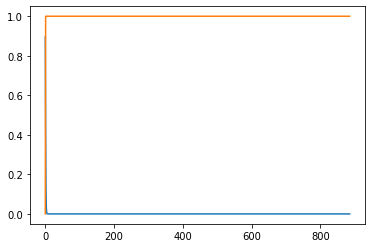

In [0]:
plt.plot(range(len(loss_curve)), loss_curve)
plt.plot(range(len(accuracy_curve)), accuracy_curve)

# Evaluating Performance

In [0]:
validation_loss_vgg_fc, validation_accuracy_vgg_fc, validation_confusion_vgg_fc = predict(vgg16, validationloader, critarion)
validation_confusion_vgg_fc

	Loss:  6.1804046630859375
	Accuracy:  0.875
	Loss:  19.695003509521484
	Accuracy:  0.5
	Loss:  9.561147689819336
	Accuracy:  0.75
	Loss:  29.893901824951172
	Accuracy:  0.25
	Loss:  21.643701553344727
	Accuracy:  0.5
	Loss:  26.086959838867188
	Accuracy:  0.375
	Loss:  22.927207946777344
	Accuracy:  0.5
	Loss:  14.40903091430664
	Accuracy:  0.625
	Loss:  12.233146667480469
	Accuracy:  0.625
	Loss:  29.91396713256836
	Accuracy:  0.375
	Loss:  25.225427627563477
	Accuracy:  0.375
	Loss:  24.94342041015625
	Accuracy:  0.375
	Loss:  18.729677200317383
	Accuracy:  0.5
	Loss:  6.047748565673828
	Accuracy:  0.875
	Loss:  10.490823745727539
	Accuracy:  0.75
	Loss:  16.62421417236328
	Accuracy:  0.625
	Loss:  16.232948303222656
	Accuracy:  0.625
	Loss:  20.022796630859375
	Accuracy:  0.5
	Loss:  21.27442169189453
	Accuracy:  0.5
	Loss:  19.970340728759766
	Accuracy:  0.5
	Loss:  12.75859260559082
	Accuracy:  0.625
	Loss:  18.83997344970703
	Accuracy:  0.625
	Loss:  23.965097427368164
	Accuracy

array([[  0, 615],
       [  0, 885]])

In [0]:
data = {'validation_loss_vgg_fc': validation_loss_vgg_fc, 'validation_accuracy_vgg_fc': validation_accuracy_vgg_fc, 'validation_confusion_vgg_fc':validation_confusion_vgg_fc}
torch.save(data, '/content/gdrive/My Drive/validation_vgg_fc.pth')

In [0]:
validation_loss_resnet_fc, validation_accuracy_resnet_fc, validation_confusion_resnet_fc = predict(resnet18, validationloader, critarion)
validation_confusion_resnet_fc

	Loss:  15.463188171386719
	Accuracy:  0.375
	Loss:  17.557031631469727
	Accuracy:  0.25
	Loss:  11.884357452392578
	Accuracy:  0.5
	Loss:  14.697543144226074
	Accuracy:  0.375
	Loss:  13.980093002319336
	Accuracy:  0.375
	Loss:  9.002860069274902
	Accuracy:  0.625
	Loss:  11.591431617736816
	Accuracy:  0.5
	Loss:  6.675618648529053
	Accuracy:  0.75
	Loss:  8.534557342529297
	Accuracy:  0.625
	Loss:  11.695515632629395
	Accuracy:  0.5
	Loss:  17.327381134033203
	Accuracy:  0.25
	Loss:  11.954187393188477
	Accuracy:  0.5
	Loss:  9.19631576538086
	Accuracy:  0.625
	Loss:  5.7886271476745605
	Accuracy:  0.75
	Loss:  6.143406867980957
	Accuracy:  0.75
	Loss:  8.711008071899414
	Accuracy:  0.625
	Loss:  7.90955924987793
	Accuracy:  0.625
	Loss:  11.946479797363281
	Accuracy:  0.5
	Loss:  11.424760818481445
	Accuracy:  0.5
	Loss:  0.0
	Accuracy:  1.0
	Loss:  3.044823408126831
	Accuracy:  0.875
	Loss:  18.635095596313477
	Accuracy:  0.25
	Loss:  17.74181365966797
	Accuracy:  0.25
	Loss:  5.45

array([[  0, 615],
       [  0, 885]])

In [0]:
data = {'validation_loss_resnet_fc': validation_loss_resnet_fc, 'validation_accuracy_resnet_fc': validation_accuracy_resnet_fc, 'validation_confusion_resnet_fc':validation_confusion_resnet_fc}
torch.save(data, '/content/gdrive/My Drive/validation_resnet_fc.pth')

In [0]:
train_loss_vgg_fc, train_accuracy_vgg_fc, train_confusion_vgg_fc = predict(vgg16, trainloader, critarion)
train_confusion_vgg_fc

	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  1.8179284779762384e-06
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  5.425825293059461e-05
	Accuracy:  1.0
	Loss:  2.9802318834981634e-08
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.00011019020894309506
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  2.9802318834981634e-08
	Accuracy:  1.0
	Loss:  0.

array([[7081]])

In [0]:
data = {'train_loss_vgg_fc': train_loss_vgg_fc, 'train_accuracy_vgg_fc': train_accuracy_vgg_fc, 'train_confusion_vgg_fc':train_confusion_vgg_fc}
torch.save(data, '/content/gdrive/My Drive/train_vgg_fc.pth')

In [0]:
train_loss_resnet_fc, train_accuracy_resnet_fc, train_confusion_resnet_fc = predict(resnet18, trainloader, critarion)
train_confusion_resnet_fc

	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  1.4901160305669237e-08
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	Loss:  0.0
	Accuracy:  1.0
	

array([[7081]])

In [0]:
data = {'train_loss_resnet_fc': train_loss_resnet_fc, 'train_accuracy_resnet_fc': train_accuracy_resnet_fc, 'train_confusion_resnet_fc':train_confusion_resnet_fc}
torch.save(data, '/content/gdrive/My Drive/train_resnet_fc.pth')

In [0]:
test_loss_vgg_fc, test_accuracy_vgg_fc, test_confusion_vgg_fc = predict(vgg16, testloader, critarion)
test_confusion_vgg_fc

	Loss:  17.417253494262695
	Accuracy:  0.625
	Loss:  11.505359649658203
	Accuracy:  0.75
	Loss:  26.711029052734375
	Accuracy:  0.375
	Loss:  15.56078052520752
	Accuracy:  0.625
	Loss:  23.819103240966797
	Accuracy:  0.5
	Loss:  15.891264915466309
	Accuracy:  0.625
	Loss:  25.212249755859375
	Accuracy:  0.375
	Loss:  17.00806427001953
	Accuracy:  0.625
	Loss:  14.469165802001953
	Accuracy:  0.625
	Loss:  5.854581832885742
	Accuracy:  0.875
	Loss:  38.86386489868164
	Accuracy:  0.125
	Loss:  11.853161811828613
	Accuracy:  0.75
	Loss:  16.50439453125
	Accuracy:  0.625
	Loss:  9.21088981628418
	Accuracy:  0.75
	Loss:  3.636493444442749
	Accuracy:  0.875
	Loss:  15.95341682434082
	Accuracy:  0.625
	Loss:  10.640183448791504
	Accuracy:  0.75
	Loss:  15.29019546508789
	Accuracy:  0.625
	Loss:  14.83964729309082
	Accuracy:  0.625
	Loss:  24.856529235839844
	Accuracy:  0.375
	Loss:  32.060062408447266
	Accuracy:  0.25
	Loss:  21.286489486694336
	Accuracy:  0.5
	Loss:  27.251712799072266
	Accur

array([[  0, 615],
       [  0, 885]])

In [0]:
data = {'test_loss_vgg_fc': test_loss_vgg_fc, 'test_accuracy_vgg_fc': test_accuracy_vgg_fc, 'test_confusion_vgg_fc':test_confusion_vgg_fc}
torch.save(data, '/content/gdrive/My Drive/test_vgg_fc.pth')

In [0]:
test_loss_resnet_fc, test_accuracy_resnet_fc, test_confusion_resnet_fc = predict(resnet18, testloader, critarion)
test_confusion_resnet_fc

	Loss:  11.540897369384766
	Accuracy:  0.5
	Loss:  12.103839874267578
	Accuracy:  0.5
	Loss:  11.24632453918457
	Accuracy:  0.5
	Loss:  6.264946937561035
	Accuracy:  0.75
	Loss:  8.437305450439453
	Accuracy:  0.625
	Loss:  0.0
	Accuracy:  1.0
	Loss:  11.925583839416504
	Accuracy:  0.5
	Loss:  11.727932929992676
	Accuracy:  0.5
	Loss:  12.396001815795898
	Accuracy:  0.5
	Loss:  8.47606372833252
	Accuracy:  0.625
	Loss:  9.535755157470703
	Accuracy:  0.625
	Loss:  8.686012268066406
	Accuracy:  0.625
	Loss:  14.660935401916504
	Accuracy:  0.375
	Loss:  5.527283668518066
	Accuracy:  0.75
	Loss:  8.643167495727539
	Accuracy:  0.625
	Loss:  3.5477380752563477
	Accuracy:  0.875
	Loss:  6.080169200897217
	Accuracy:  0.75
	Loss:  5.956690788269043
	Accuracy:  0.75
	Loss:  11.706756591796875
	Accuracy:  0.5
	Loss:  5.752021789550781
	Accuracy:  0.75
	Loss:  8.898017883300781
	Accuracy:  0.625
	Loss:  11.314138412475586
	Accuracy:  0.5
	Loss:  6.09364128112793
	Accuracy:  0.75
	Loss:  5.652252197

array([[  0, 615],
       [  0, 885]])

In [0]:
data = {'test_loss_resnet_fc': test_loss_resnet_fc, 'test_accuracy_resnet_fc': test_accuracy_resnet_fc, 'test_confusion_resnet_fc':test_confusion_resnet_fc}
torch.save(data, '/content/gdrive/My Drive/test_resnet_fc.pth')

# Task 2

## Fine tuning of VGG16

In [0]:
# loading pretrained models
vgg16 = models.vgg16(pretrained=True)

print(vgg16)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# creating fc layers
# Roll no. MSDS19019 => 19*10+100 = 290


vgg_num_features = vgg16.classifier[0].in_features

vgg_fc = [
    nn.Linear(vgg_num_features, 290), 
    nn.ReLU(), 
    nn.Linear(290, len(train_data.classes))
]

vgg_fc

[Linear(in_features=25088, out_features=290, bias=True),
 ReLU(),
 Linear(in_features=290, out_features=2, bias=True)]

In [0]:
# adding our own fc layers in pretrained vgg16 and resnet18 nets

vgg16.classifier = nn.Sequential(*vgg_fc)


In [0]:
# freezing all layers

for param in vgg16.parameters():
    param.requires_grad = False



In [0]:
# unfreezing our self added fc layers

for param in vgg16.classifier.parameters():
    param.requires_grad = True


In [0]:
# unfreezing first layer, that is convolutional layer of both net

for param in vgg16.parameters():
    param.requires_grad = True
    break


In [0]:
# check freezing status of all layers of vgg16 net
for param in vgg16.parameters():
    print(param.requires_grad)

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True


In [0]:
epochs = 1
critarion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), 0.01, 0.9)
loss_curve, accuracy_curve = train(vgg16, epochs, trainloader, critarion, optimizer)


0it [00:00, ?it/s]

Device:  cpu



1it [00:08,  8.83s/it]

	Loss: 0.6124301552772522 	Accuracy: 1.0



2it [00:17,  8.80s/it]

	Loss: 0.01649371162056923 	Accuracy: 1.0



3it [00:26,  8.70s/it]

	Loss: 0.0012658694759011269 	Accuracy: 1.0



4it [00:34,  8.62s/it]

	Loss: 4.125644773012027e-05 	Accuracy: 1.0



5it [00:42,  8.56s/it]

	Loss: 2.2351736106429598e-07 	Accuracy: 1.0



6it [00:51,  8.52s/it]

	Loss: 0.0015323045663535595 	Accuracy: 1.0



7it [00:59,  8.50s/it]

	Loss: 1.8477303456165828e-06 	Accuracy: 1.0



8it [01:08,  8.49s/it]

	Loss: 1.6242159972534864e-06 	Accuracy: 1.0



9it [01:16,  8.46s/it]

	Loss: 1.3411037969035533e-07 	Accuracy: 1.0



10it [01:25,  8.46s/it]

	Loss: 0.0 	Accuracy: 1.0



11it [01:33,  8.46s/it]

	Loss: 0.0 	Accuracy: 1.0



12it [01:42,  8.47s/it]

	Loss: 0.0 	Accuracy: 1.0



13it [01:50,  8.45s/it]

	Loss: 0.0 	Accuracy: 1.0



14it [01:58,  8.43s/it]

	Loss: 0.0 	Accuracy: 1.0



15it [02:07,  8.42s/it]

	Loss: 0.0 	Accuracy: 1.0



16it [02:15,  8.44s/it]

	Loss: 0.0 	Accuracy: 1.0



17it [02:24,  8.43s/it]

	Loss: 0.0 	Accuracy: 1.0


KeyboardInterrupt: ignored

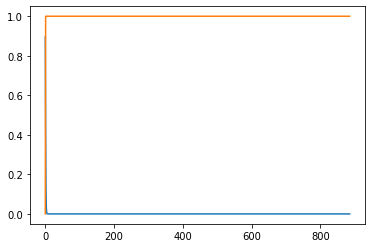

In [0]:
plt.plot(range(len(loss_curve)), loss_curve)
plt.plot(range(len(accuracy_curve)), accuracy_curve)

In [0]:
# unfreezing all layers

for param in vgg16.parameters():
    param.requires_grad = True


In [0]:
epochs = 1
critarion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), 0.01, 0.9)
loss_curve, accuracy_curve = train(vgg16, epochs, trainloader, critarion, optimizer)



0it [00:00, ?it/s]

Device:  cpu




1it [00:13, 13.38s/it]

	Loss: 0.0 	Accuracy: 1.0




2it [00:27, 13.63s/it]

	Loss: 0.0 	Accuracy: 1.0




3it [00:41, 13.80s/it]

	Loss: 0.0 	Accuracy: 1.0




4it [00:55, 13.89s/it]

	Loss: 0.0 	Accuracy: 1.0




5it [01:09, 13.73s/it]

	Loss: 0.0 	Accuracy: 1.0




6it [01:24, 14.11s/it]

	Loss: 0.0 	Accuracy: 1.0




7it [01:58, 20.15s/it]

	Loss: 0.0 	Accuracy: 1.0




8it [02:12, 18.37s/it]

	Loss: 0.0 	Accuracy: 1.0




9it [02:26, 16.85s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




10it [02:39, 15.80s/it]

	Loss: 0.0 	Accuracy: 1.0




11it [02:52, 15.08s/it]

	Loss: 0.0 	Accuracy: 1.0




12it [03:06, 14.57s/it]

	Loss: 0.0 	Accuracy: 1.0




13it [03:21, 14.70s/it]

	Loss: 0.0 	Accuracy: 1.0




14it [03:34, 14.31s/it]

	Loss: 0.0 	Accuracy: 1.0




15it [03:47, 14.03s/it]

	Loss: 0.0 	Accuracy: 1.0




16it [04:01, 13.83s/it]

	Loss: 0.0 	Accuracy: 1.0




17it [04:14, 13.68s/it]

	Loss: 0.0 	Accuracy: 1.0




18it [04:28, 13.60s/it]

	Loss: 0.0 	Accuracy: 1.0




19it [04:41, 13.55s/it]

	Loss: 0.0 	Accuracy: 1.0




20it [04:54, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




21it [05:08, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




22it [05:21, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




23it [05:35, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




24it [05:48, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




25it [06:01, 13.42s/it]

	Loss: 0.0 	Accuracy: 1.0




26it [06:15, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




27it [06:28, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




28it [06:42, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




29it [06:55, 13.39s/it]

	Loss: 0.0 	Accuracy: 1.0




30it [07:08, 13.39s/it]

	Loss: 0.0 	Accuracy: 1.0




31it [07:22, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




32it [07:39, 14.59s/it]

	Loss: 4.1723183130670805e-07 	Accuracy: 1.0




33it [07:52, 14.22s/it]

	Loss: 0.0 	Accuracy: 1.0




34it [08:06, 13.98s/it]

	Loss: 0.0 	Accuracy: 1.0




35it [08:19, 13.79s/it]

	Loss: 0.0 	Accuracy: 1.0




36it [08:33, 13.67s/it]

	Loss: 0.0 	Accuracy: 1.0




37it [08:46, 13.60s/it]

	Loss: 0.0 	Accuracy: 1.0




38it [09:00, 13.71s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0




39it [10:04, 28.90s/it]

	Loss: 0.0 	Accuracy: 1.0




40it [10:18, 24.28s/it]

	Loss: 0.0 	Accuracy: 1.0




41it [10:31, 21.02s/it]

	Loss: 0.0 	Accuracy: 1.0




42it [10:45, 18.87s/it]

	Loss: 0.0 	Accuracy: 1.0




43it [10:59, 17.24s/it]

	Loss: 0.0 	Accuracy: 1.0




44it [11:12, 16.08s/it]

	Loss: 0.0 	Accuracy: 1.0




45it [11:38, 18.98s/it]

	Loss: 0.0 	Accuracy: 1.0




46it [11:51, 17.29s/it]

	Loss: 0.0 	Accuracy: 1.0




47it [12:10, 17.80s/it]

	Loss: 0.0 	Accuracy: 1.0




48it [12:23, 16.47s/it]

	Loss: 0.0 	Accuracy: 1.0




49it [12:37, 15.57s/it]

	Loss: 0.0 	Accuracy: 1.0




50it [12:51, 15.05s/it]

	Loss: 0.0 	Accuracy: 1.0




51it [13:04, 14.55s/it]

	Loss: 0.0 	Accuracy: 1.0




52it [13:17, 14.18s/it]

	Loss: 0.0 	Accuracy: 1.0




53it [13:31, 13.93s/it]

	Loss: 0.0 	Accuracy: 1.0




54it [13:44, 13.75s/it]

	Loss: 0.0 	Accuracy: 1.0




55it [13:58, 13.65s/it]

	Loss: 0.0 	Accuracy: 1.0




56it [14:11, 13.61s/it]

	Loss: 0.0 	Accuracy: 1.0




57it [14:24, 13.55s/it]

	Loss: 0.0 	Accuracy: 1.0




58it [14:38, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




59it [14:51, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




60it [15:05, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




61it [15:18, 13.43s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0




62it [15:31, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




63it [15:45, 13.45s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




64it [16:01, 14.33s/it]

	Loss: 0.0 	Accuracy: 1.0




65it [16:15, 14.02s/it]

	Loss: 0.0 	Accuracy: 1.0




66it [16:28, 13.84s/it]

	Loss: 0.0 	Accuracy: 1.0




67it [16:41, 13.71s/it]

	Loss: 0.0 	Accuracy: 1.0




68it [16:55, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




69it [17:08, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




70it [17:22, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




71it [17:35, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




72it [17:48, 13.42s/it]

	Loss: 0.0 	Accuracy: 1.0




73it [18:02, 13.42s/it]

	Loss: 0.0 	Accuracy: 1.0




74it [18:15, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




75it [18:28, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




76it [19:25, 26.20s/it]

	Loss: 0.0 	Accuracy: 1.0




77it [19:38, 22.34s/it]

	Loss: 0.0 	Accuracy: 1.0




78it [19:51, 19.66s/it]

	Loss: 0.0 	Accuracy: 1.0




79it [20:05, 17.82s/it]

	Loss: 0.0 	Accuracy: 1.0




80it [20:19, 16.59s/it]

	Loss: 0.0 	Accuracy: 1.0




81it [20:32, 15.62s/it]

	Loss: 0.0 	Accuracy: 1.0




82it [20:45, 14.96s/it]

	Loss: 0.0 	Accuracy: 1.0




83it [20:59, 14.50s/it]

	Loss: 0.0 	Accuracy: 1.0




84it [21:12, 14.16s/it]

	Loss: 0.0 	Accuracy: 1.0




85it [21:26, 13.95s/it]

	Loss: 0.0 	Accuracy: 1.0




86it [21:39, 13.77s/it]

	Loss: 0.0 	Accuracy: 1.0




87it [21:52, 13.66s/it]

	Loss: 7.450578465295621e-08 	Accuracy: 1.0




88it [22:06, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




89it [22:19, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




90it [22:32, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




91it [22:46, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




92it [22:59, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




93it [23:13, 13.42s/it]

	Loss: 0.0 	Accuracy: 1.0




94it [23:26, 13.38s/it]

	Loss: 0.0 	Accuracy: 1.0




95it [23:39, 13.37s/it]

	Loss: 0.0 	Accuracy: 1.0




96it [23:53, 13.38s/it]

	Loss: 0.0 	Accuracy: 1.0




97it [24:12, 15.24s/it]

	Loss: 0.0 	Accuracy: 1.0




98it [24:26, 14.70s/it]

	Loss: 0.0 	Accuracy: 1.0




99it [24:39, 14.32s/it]

	Loss: 0.0 	Accuracy: 1.0




100it [24:52, 14.04s/it]

	Loss: 0.0 	Accuracy: 1.0




101it [25:06, 13.85s/it]

	Loss: 0.0 	Accuracy: 1.0




102it [25:20, 13.83s/it]

	Loss: 0.0 	Accuracy: 1.0




103it [25:33, 13.70s/it]

	Loss: 1.7881380642847944e-07 	Accuracy: 1.0




104it [25:48, 14.11s/it]

	Loss: 0.0 	Accuracy: 1.0




105it [26:01, 13.91s/it]

	Loss: 0.0 	Accuracy: 1.0




106it [26:16, 14.14s/it]

	Loss: 0.0 	Accuracy: 1.0




107it [26:39, 16.66s/it]

	Loss: 0.0 	Accuracy: 1.0




108it [26:52, 15.68s/it]

	Loss: 0.0 	Accuracy: 1.0




109it [27:05, 14.99s/it]

	Loss: 0.0 	Accuracy: 1.0




110it [27:19, 14.51s/it]

	Loss: 0.0 	Accuracy: 1.0




111it [27:32, 14.18s/it]

	Loss: 0.0 	Accuracy: 1.0




112it [27:46, 13.97s/it]

	Loss: 0.0 	Accuracy: 1.0




113it [27:59, 13.84s/it]

	Loss: 0.0 	Accuracy: 1.0




114it [28:14, 14.00s/it]

	Loss: 0.0 	Accuracy: 1.0




115it [28:27, 13.83s/it]

	Loss: 0.0 	Accuracy: 1.0




116it [28:41, 13.73s/it]

	Loss: 0.0 	Accuracy: 1.0




117it [28:54, 13.77s/it]

	Loss: 0.0 	Accuracy: 1.0




118it [29:08, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




119it [29:21, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




120it [29:34, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




121it [29:48, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




122it [30:01, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




123it [30:15, 13.43s/it]

	Loss: 1.1920923270736239e-07 	Accuracy: 1.0




124it [30:28, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




125it [30:41, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




126it [30:55, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




127it [31:08, 13.42s/it]

	Loss: 0.0 	Accuracy: 1.0




128it [31:22, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




129it [31:35, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




130it [31:49, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




131it [32:20, 18.76s/it]

	Loss: 0.0 	Accuracy: 1.0




132it [32:33, 17.16s/it]

	Loss: 7.74857994656486e-07 	Accuracy: 1.0




133it [32:47, 16.07s/it]

	Loss: 0.0 	Accuracy: 1.0




134it [33:00, 15.34s/it]

	Loss: 0.0 	Accuracy: 1.0




135it [33:14, 14.84s/it]

	Loss: 0.0 	Accuracy: 1.0




136it [33:28, 14.47s/it]

	Loss: 0.0 	Accuracy: 1.0




137it [33:41, 14.15s/it]

	Loss: 0.0 	Accuracy: 1.0




138it [33:55, 13.94s/it]

	Loss: 0.0 	Accuracy: 1.0




139it [34:08, 13.79s/it]

	Loss: 4.847897798754275e-05 	Accuracy: 1.0




140it [34:22, 13.72s/it]

	Loss: 0.0 	Accuracy: 1.0




141it [34:35, 13.65s/it]

	Loss: 0.0 	Accuracy: 1.0




142it [34:49, 13.74s/it]

	Loss: 0.0 	Accuracy: 1.0




143it [35:02, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




144it [35:16, 13.58s/it]

	Loss: 0.0 	Accuracy: 1.0




145it [35:29, 13.55s/it]

	Loss: 0.0 	Accuracy: 1.0




146it [35:43, 13.53s/it]

	Loss: 0.0 	Accuracy: 1.0




147it [35:56, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




148it [36:10, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




149it [36:23, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




150it [36:37, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




151it [36:50, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




152it [37:04, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




153it [37:18, 13.63s/it]

	Loss: 0.0 	Accuracy: 1.0




154it [37:31, 13.55s/it]

	Loss: 0.0 	Accuracy: 1.0




155it [37:46, 13.90s/it]

	Loss: 0.0 	Accuracy: 1.0




156it [37:59, 13.79s/it]

	Loss: 0.0 	Accuracy: 1.0




157it [38:13, 13.79s/it]

	Loss: 0.0 	Accuracy: 1.0




158it [38:26, 13.69s/it]

	Loss: 0.0 	Accuracy: 1.0




159it [38:40, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




160it [38:53, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




161it [39:20, 17.54s/it]

	Loss: 0.0 	Accuracy: 1.0




162it [39:34, 16.30s/it]

	Loss: 0.0 	Accuracy: 1.0




163it [39:47, 15.46s/it]

	Loss: 0.0 	Accuracy: 1.0




164it [40:01, 14.88s/it]

	Loss: 0.0 	Accuracy: 1.0




165it [40:14, 14.47s/it]

	Loss: 0.0 	Accuracy: 1.0




166it [40:28, 14.24s/it]

	Loss: 0.0 	Accuracy: 1.0




167it [40:41, 13.99s/it]

	Loss: 0.0 	Accuracy: 1.0




168it [40:55, 13.82s/it]

	Loss: 0.0 	Accuracy: 1.0




169it [41:08, 13.72s/it]

	Loss: 0.0 	Accuracy: 1.0




170it [41:35, 17.82s/it]

	Loss: 0.0 	Accuracy: 1.0




171it [41:49, 16.50s/it]

	Loss: 0.0 	Accuracy: 1.0




172it [42:02, 15.63s/it]

	Loss: 0.0 	Accuracy: 1.0




173it [42:16, 14.95s/it]

	Loss: 0.0 	Accuracy: 1.0




174it [42:29, 14.52s/it]

	Loss: 0.0 	Accuracy: 1.0




175it [42:43, 14.23s/it]

	Loss: 0.0 	Accuracy: 1.0




176it [42:56, 13.99s/it]

	Loss: 0.0 	Accuracy: 1.0




177it [43:10, 13.91s/it]

	Loss: 0.0 	Accuracy: 1.0




178it [43:23, 13.74s/it]

	Loss: 0.0 	Accuracy: 1.0




179it [43:37, 13.65s/it]

	Loss: 0.0 	Accuracy: 1.0




180it [43:50, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




181it [44:04, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




182it [44:17, 13.53s/it]

	Loss: 0.0 	Accuracy: 1.0




183it [44:31, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




184it [44:44, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




185it [44:58, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




186it [45:11, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




187it [45:25, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




188it [45:38, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




189it [45:51, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




190it [46:05, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




191it [46:18, 13.38s/it]

	Loss: 0.0 	Accuracy: 1.0




192it [46:31, 13.39s/it]

	Loss: 0.0 	Accuracy: 1.0




193it [46:45, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




194it [46:58, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




195it [47:12, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




196it [47:25, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




197it [47:38, 13.38s/it]

	Loss: 0.0 	Accuracy: 1.0




198it [47:52, 13.39s/it]

	Loss: 0.0 	Accuracy: 1.0




199it [48:05, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




200it [48:19, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




201it [48:32, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




202it [48:46, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




203it [48:59, 13.39s/it]

	Loss: 0.0 	Accuracy: 1.0




204it [49:12, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




205it [49:26, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




206it [49:43, 14.54s/it]

	Loss: 0.0 	Accuracy: 1.0




207it [49:56, 14.21s/it]

	Loss: 0.0 	Accuracy: 1.0




208it [50:10, 13.95s/it]

	Loss: 0.0 	Accuracy: 1.0




209it [50:23, 13.78s/it]

	Loss: 0.0 	Accuracy: 1.0




210it [50:37, 13.68s/it]

	Loss: 0.0 	Accuracy: 1.0




211it [50:50, 13.63s/it]

	Loss: 0.0 	Accuracy: 1.0




212it [51:04, 13.61s/it]

	Loss: 0.0 	Accuracy: 1.0




213it [51:17, 13.55s/it]

	Loss: 0.0 	Accuracy: 1.0




214it [51:30, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




215it [52:34, 28.68s/it]

	Loss: 0.0 	Accuracy: 1.0




216it [52:48, 24.14s/it]

	Loss: 0.0 	Accuracy: 1.0




217it [53:03, 21.48s/it]

	Loss: 0.0 	Accuracy: 1.0




218it [53:17, 19.06s/it]

	Loss: 0.0 	Accuracy: 1.0




219it [53:30, 17.37s/it]

	Loss: 0.0 	Accuracy: 1.0




220it [53:44, 16.19s/it]

	Loss: 0.0 	Accuracy: 1.0




221it [53:57, 15.35s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




222it [54:10, 14.79s/it]

	Loss: 0.0 	Accuracy: 1.0




223it [54:32, 16.95s/it]

	Loss: 0.0 	Accuracy: 1.0




224it [54:46, 15.95s/it]

	Loss: 0.0 	Accuracy: 1.0




225it [54:59, 15.19s/it]

	Loss: 0.0 	Accuracy: 1.0




226it [55:13, 14.67s/it]

	Loss: 0.0 	Accuracy: 1.0




227it [55:26, 14.29s/it]

	Loss: 0.0 	Accuracy: 1.0




228it [55:40, 14.05s/it]

	Loss: 0.0 	Accuracy: 1.0




229it [55:53, 13.86s/it]

	Loss: 0.0 	Accuracy: 1.0




230it [56:07, 13.73s/it]

	Loss: 0.0 	Accuracy: 1.0




231it [56:20, 13.62s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




232it [56:46, 17.41s/it]

	Loss: 0.0 	Accuracy: 1.0




233it [57:00, 16.25s/it]

	Loss: 0.0 	Accuracy: 1.0




234it [57:13, 15.43s/it]

	Loss: 0.0 	Accuracy: 1.0




235it [57:27, 14.82s/it]

	Loss: 0.0 	Accuracy: 1.0




236it [57:40, 14.38s/it]

	Loss: 0.0 	Accuracy: 1.0




237it [57:53, 14.08s/it]

	Loss: 0.0 	Accuracy: 1.0




238it [58:07, 13.91s/it]

	Loss: 0.0 	Accuracy: 1.0




239it [58:21, 13.82s/it]

	Loss: 0.0 	Accuracy: 1.0




240it [58:34, 13.72s/it]

	Loss: 0.0 	Accuracy: 1.0




241it [58:48, 13.86s/it]

	Loss: 0.0 	Accuracy: 1.0




242it [59:02, 13.70s/it]

	Loss: 0.0 	Accuracy: 1.0




243it [59:15, 13.59s/it]

	Loss: 0.0 	Accuracy: 1.0




244it [59:28, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




245it [59:42, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




246it [59:55, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




247it [1:00:09, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




248it [1:00:22, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




249it [1:00:36, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




250it [1:00:49, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




251it [1:01:02, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




252it [1:01:16, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




253it [1:01:29, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




254it [1:01:43, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




255it [1:01:56, 13.38s/it]

	Loss: 0.0 	Accuracy: 1.0




256it [1:02:10, 13.46s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0




257it [1:02:23, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




258it [1:02:37, 13.74s/it]

	Loss: 0.0 	Accuracy: 1.0




259it [1:02:51, 13.64s/it]

	Loss: 1.9073340808972716e-06 	Accuracy: 1.0




260it [1:03:04, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




261it [1:03:18, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




262it [1:03:31, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




263it [1:04:33, 28.06s/it]

	Loss: 0.0 	Accuracy: 1.0




264it [1:04:49, 24.42s/it]

	Loss: 0.0 	Accuracy: 1.0




265it [1:05:02, 21.13s/it]

	Loss: 0.0 	Accuracy: 1.0




266it [1:05:16, 18.80s/it]

	Loss: 0.0 	Accuracy: 1.0




267it [1:05:29, 17.17s/it]

	Loss: 0.0 	Accuracy: 1.0




268it [1:05:43, 16.03s/it]

	Loss: 0.0 	Accuracy: 1.0




269it [1:05:56, 15.23s/it]

	Loss: 0.0 	Accuracy: 1.0




270it [1:06:09, 14.68s/it]

	Loss: 0.0 	Accuracy: 1.0




271it [1:06:23, 14.28s/it]

	Loss: 0.0 	Accuracy: 1.0




272it [1:06:36, 14.01s/it]

	Loss: 0.0 	Accuracy: 1.0




273it [1:06:49, 13.82s/it]

	Loss: 0.0 	Accuracy: 1.0




274it [1:07:03, 13.79s/it]

	Loss: 0.0 	Accuracy: 1.0




275it [1:07:16, 13.66s/it]

	Loss: 0.0 	Accuracy: 1.0




276it [1:07:30, 13.58s/it]

	Loss: 0.0 	Accuracy: 1.0




277it [1:07:43, 13.53s/it]

	Loss: 0.0 	Accuracy: 1.0




278it [1:08:25, 21.88s/it]

	Loss: 0.0 	Accuracy: 1.0




279it [1:08:38, 19.34s/it]

	Loss: 0.0 	Accuracy: 1.0




280it [1:08:51, 17.54s/it]

	Loss: 0.0 	Accuracy: 1.0




281it [1:09:05, 16.28s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




282it [1:09:18, 15.39s/it]

	Loss: 1.1920923270736239e-07 	Accuracy: 1.0




283it [1:09:31, 14.79s/it]

	Loss: 0.0 	Accuracy: 1.0




284it [1:09:45, 14.55s/it]

	Loss: 0.0 	Accuracy: 1.0




285it [1:10:25, 21.98s/it]

	Loss: 0.0 	Accuracy: 1.0




286it [1:10:38, 19.41s/it]

	Loss: 0.0 	Accuracy: 1.0




287it [1:10:52, 17.60s/it]

	Loss: 0.0 	Accuracy: 1.0




288it [1:11:05, 16.32s/it]

	Loss: 0.0 	Accuracy: 1.0




289it [1:11:18, 15.43s/it]

	Loss: 8.195611940209346e-07 	Accuracy: 1.0




290it [1:11:32, 14.98s/it]

	Loss: 0.0 	Accuracy: 1.0




291it [1:11:46, 14.49s/it]

	Loss: 0.0 	Accuracy: 1.0




292it [1:11:59, 14.13s/it]

	Loss: 0.0 	Accuracy: 1.0




293it [1:12:12, 13.91s/it]

	Loss: 0.0 	Accuracy: 1.0




294it [1:12:26, 13.78s/it]

	Loss: 0.0 	Accuracy: 1.0




295it [1:12:39, 13.69s/it]

	Loss: 0.0 	Accuracy: 1.0




296it [1:12:52, 13.58s/it]

	Loss: 0.0 	Accuracy: 1.0




297it [1:13:06, 13.53s/it]

	Loss: 0.0 	Accuracy: 1.0




298it [1:13:19, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




299it [1:13:33, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




300it [1:13:46, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




301it [1:14:00, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




302it [1:14:14, 13.73s/it]

	Loss: 0.0 	Accuracy: 1.0




303it [1:14:29, 14.01s/it]

	Loss: 0.0 	Accuracy: 1.0




304it [1:14:42, 13.82s/it]

	Loss: 0.0 	Accuracy: 1.0




305it [1:15:01, 15.42s/it]

	Loss: 0.0 	Accuracy: 1.0




306it [1:15:15, 14.86s/it]

	Loss: 0.0 	Accuracy: 1.0




307it [1:15:28, 14.44s/it]

	Loss: 0.0 	Accuracy: 1.0




308it [1:15:43, 14.47s/it]

	Loss: 0.0 	Accuracy: 1.0




309it [1:15:56, 14.14s/it]

	Loss: 0.0 	Accuracy: 1.0




310it [1:16:09, 13.93s/it]

	Loss: 0.0 	Accuracy: 1.0




311it [1:16:23, 13.78s/it]

	Loss: 0.0 	Accuracy: 1.0




312it [1:16:36, 13.70s/it]

	Loss: 0.0 	Accuracy: 1.0




313it [1:16:50, 13.62s/it]

	Loss: 0.0 	Accuracy: 1.0




314it [1:17:03, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




315it [1:17:18, 13.99s/it]

	Loss: 0.0 	Accuracy: 1.0




316it [1:17:32, 13.81s/it]

	Loss: 0.0 	Accuracy: 1.0




317it [1:17:46, 13.83s/it]

	Loss: 0.0 	Accuracy: 1.0




318it [1:18:27, 22.19s/it]

	Loss: 0.0 	Accuracy: 1.0




319it [1:18:41, 19.57s/it]

	Loss: 0.0 	Accuracy: 1.0




320it [1:18:54, 17.71s/it]

	Loss: 0.0 	Accuracy: 1.0




321it [1:19:14, 18.45s/it]

	Loss: 0.0 	Accuracy: 1.0




322it [1:19:28, 16.93s/it]

	Loss: 0.0 	Accuracy: 1.0




323it [1:19:41, 15.90s/it]

	Loss: 0.0 	Accuracy: 1.0




324it [1:19:55, 15.18s/it]

	Loss: 0.0 	Accuracy: 1.0




325it [1:20:09, 14.91s/it]

	Loss: 0.0 	Accuracy: 1.0




326it [1:20:22, 14.48s/it]

	Loss: 0.0 	Accuracy: 1.0




327it [1:20:36, 14.17s/it]

	Loss: 0.0 	Accuracy: 1.0




328it [1:20:49, 13.96s/it]

	Loss: 0.0 	Accuracy: 1.0




329it [1:21:03, 13.81s/it]

	Loss: 0.0 	Accuracy: 1.0




330it [1:21:28, 17.34s/it]

	Loss: 0.0 	Accuracy: 1.0




331it [1:21:42, 16.18s/it]

	Loss: 0.0 	Accuracy: 1.0




332it [1:21:55, 15.34s/it]

	Loss: 0.0 	Accuracy: 1.0




333it [1:22:09, 14.77s/it]

	Loss: 0.0 	Accuracy: 1.0




334it [1:22:22, 14.38s/it]

	Loss: 0.0 	Accuracy: 1.0




335it [1:22:36, 14.10s/it]

	Loss: 0.0 	Accuracy: 1.0




336it [1:22:49, 13.89s/it]

	Loss: 0.0 	Accuracy: 1.0




337it [1:23:02, 13.77s/it]

	Loss: 0.0 	Accuracy: 1.0




338it [1:23:16, 13.76s/it]

	Loss: 0.0 	Accuracy: 1.0




339it [1:23:30, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




340it [1:23:43, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




341it [1:23:56, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




342it [1:24:22, 17.24s/it]

	Loss: 0.0 	Accuracy: 1.0




343it [1:24:36, 16.10s/it]

	Loss: 0.0 	Accuracy: 1.0




344it [1:24:49, 15.30s/it]

	Loss: 0.0 	Accuracy: 1.0




345it [1:25:02, 14.74s/it]

	Loss: 0.0 	Accuracy: 1.0




346it [1:25:23, 16.43s/it]

	Loss: 0.0 	Accuracy: 1.0




347it [1:25:36, 15.53s/it]

	Loss: 0.0 	Accuracy: 1.0




348it [1:26:01, 18.21s/it]

	Loss: 0.0 	Accuracy: 1.0




349it [1:26:15, 17.15s/it]

	Loss: 0.0 	Accuracy: 1.0




350it [1:26:29, 16.03s/it]

	Loss: 0.0 	Accuracy: 1.0




351it [1:26:42, 15.28s/it]

	Loss: 0.0 	Accuracy: 1.0




352it [1:26:56, 14.74s/it]

	Loss: 0.0 	Accuracy: 1.0




353it [1:27:09, 14.35s/it]

	Loss: 0.0 	Accuracy: 1.0




354it [1:27:23, 14.07s/it]

	Loss: 0.0 	Accuracy: 1.0




355it [1:27:36, 13.87s/it]

	Loss: 0.0 	Accuracy: 1.0




356it [1:27:51, 14.11s/it]

	Loss: 0.0 	Accuracy: 1.0




357it [1:28:04, 13.92s/it]

	Loss: 0.0 	Accuracy: 1.0




358it [1:28:57, 25.62s/it]

	Loss: 0.0 	Accuracy: 1.0




359it [1:29:11, 21.97s/it]

	Loss: 0.0 	Accuracy: 1.0




360it [1:29:24, 19.39s/it]

	Loss: 0.0 	Accuracy: 1.0




361it [1:29:38, 17.69s/it]

	Loss: 0.0 	Accuracy: 1.0




362it [1:29:51, 16.48s/it]

	Loss: 0.0 	Accuracy: 1.0




363it [1:30:21, 20.32s/it]

	Loss: 1.2665923350141384e-06 	Accuracy: 1.0




364it [1:30:35, 18.41s/it]

	Loss: 0.0 	Accuracy: 1.0




365it [1:30:48, 16.92s/it]

	Loss: 0.0 	Accuracy: 1.0




366it [1:31:02, 15.96s/it]

	Loss: 0.0 	Accuracy: 1.0




367it [1:31:17, 15.80s/it]

	Loss: 0.0 	Accuracy: 1.0




368it [1:31:31, 15.07s/it]

	Loss: 0.0 	Accuracy: 1.0




369it [1:31:44, 14.59s/it]

	Loss: 0.0 	Accuracy: 1.0




370it [1:31:57, 14.23s/it]

	Loss: 0.0 	Accuracy: 1.0




371it [1:32:11, 14.00s/it]

	Loss: 0.0 	Accuracy: 1.0




372it [1:32:24, 13.80s/it]

	Loss: 0.0 	Accuracy: 1.0




373it [1:32:41, 14.74s/it]

	Loss: 0.0 	Accuracy: 1.0




374it [1:32:55, 14.38s/it]

	Loss: 0.0 	Accuracy: 1.0




375it [1:33:08, 14.12s/it]

	Loss: 0.0 	Accuracy: 1.0




376it [1:33:22, 13.93s/it]

	Loss: 0.0 	Accuracy: 1.0




377it [1:33:35, 13.78s/it]

	Loss: 0.0 	Accuracy: 1.0




378it [1:33:49, 13.69s/it]

	Loss: 0.0 	Accuracy: 1.0




379it [1:34:02, 13.61s/it]

	Loss: 0.0 	Accuracy: 1.0




380it [1:34:15, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




381it [1:34:29, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




382it [1:34:42, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




383it [1:34:56, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




384it [1:35:09, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




385it [1:35:23, 13.47s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




386it [1:35:36, 13.48s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0




387it [1:35:50, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




388it [1:36:03, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




389it [1:36:16, 13.43s/it]

	Loss: 2.637477791722631e-06 	Accuracy: 1.0




390it [1:36:30, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




391it [1:36:43, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




392it [1:36:57, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




393it [1:37:11, 13.61s/it]

	Loss: 0.0 	Accuracy: 1.0




394it [1:37:24, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




395it [1:37:38, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




396it [1:37:51, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




397it [1:38:05, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




398it [1:38:18, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




399it [1:38:34, 14.10s/it]

	Loss: 0.0 	Accuracy: 1.0




400it [1:38:47, 13.92s/it]

	Loss: 0.0 	Accuracy: 1.0




401it [1:39:01, 13.88s/it]

	Loss: 0.0 	Accuracy: 1.0




402it [1:39:14, 13.77s/it]

	Loss: 0.0 	Accuracy: 1.0




403it [1:39:28, 13.69s/it]

	Loss: 0.0 	Accuracy: 1.0




404it [1:39:41, 13.62s/it]

	Loss: 0.0 	Accuracy: 1.0




405it [1:39:55, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




406it [1:40:08, 13.55s/it]

	Loss: 0.0 	Accuracy: 1.0




407it [1:40:22, 13.55s/it]

	Loss: 0.0 	Accuracy: 1.0




408it [1:40:38, 14.24s/it]

	Loss: 0.0 	Accuracy: 1.0




409it [1:40:52, 14.19s/it]

	Loss: 0.0 	Accuracy: 1.0




410it [1:41:05, 13.98s/it]

	Loss: 0.0 	Accuracy: 1.0




411it [1:41:27, 16.40s/it]

	Loss: 0.0 	Accuracy: 1.0




412it [1:41:48, 17.78s/it]

	Loss: 0.0 	Accuracy: 1.0




413it [1:42:03, 16.75s/it]

	Loss: 0.0 	Accuracy: 1.0




414it [1:42:16, 15.74s/it]

	Loss: 5.960463056453591e-08 	Accuracy: 1.0




415it [1:42:29, 15.03s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




416it [1:42:43, 14.55s/it]

	Loss: 0.0 	Accuracy: 1.0




417it [1:42:56, 14.23s/it]

	Loss: 0.0 	Accuracy: 1.0




418it [1:43:10, 14.08s/it]

	Loss: 0.0 	Accuracy: 1.0




419it [1:43:23, 13.88s/it]

	Loss: 0.0 	Accuracy: 1.0




420it [1:43:37, 13.74s/it]

	Loss: 0.0 	Accuracy: 1.0




421it [1:43:51, 13.76s/it]

	Loss: 0.0 	Accuracy: 1.0




422it [1:44:04, 13.66s/it]

	Loss: 0.0 	Accuracy: 1.0




423it [1:44:18, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




424it [1:44:31, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




425it [1:44:45, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




426it [1:44:58, 13.61s/it]

	Loss: 0.0 	Accuracy: 1.0




427it [1:45:16, 14.69s/it]

	Loss: 1.8356882719672285e-05 	Accuracy: 1.0




428it [1:45:29, 14.29s/it]

	Loss: 0.0 	Accuracy: 1.0




429it [1:45:43, 14.07s/it]

	Loss: 7.599361197208054e-06 	Accuracy: 1.0




430it [1:45:56, 13.87s/it]

	Loss: 0.0 	Accuracy: 1.0




431it [1:46:09, 13.73s/it]

	Loss: 0.0 	Accuracy: 1.0




432it [1:46:23, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




433it [1:46:36, 13.58s/it]

	Loss: 0.0 	Accuracy: 1.0




434it [1:46:50, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




435it [1:47:03, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




436it [1:47:17, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




437it [1:47:30, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




438it [1:47:43, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




439it [1:47:57, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




440it [1:48:10, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




441it [1:48:24, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




442it [1:48:37, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




443it [1:48:51, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




444it [1:49:15, 16.73s/it]

	Loss: 0.0 	Accuracy: 1.0




445it [1:49:28, 15.73s/it]

	Loss: 0.0 	Accuracy: 1.0




446it [1:49:42, 15.05s/it]

	Loss: 0.0 	Accuracy: 1.0




447it [1:49:56, 14.69s/it]

	Loss: 0.0 	Accuracy: 1.0




448it [1:50:09, 14.31s/it]

	Loss: 0.0 	Accuracy: 1.0




449it [1:50:23, 14.06s/it]

	Loss: 0.0 	Accuracy: 1.0




450it [1:50:36, 13.90s/it]

	Loss: 0.0 	Accuracy: 1.0




451it [1:50:51, 14.25s/it]

	Loss: 0.0 	Accuracy: 1.0




452it [1:51:05, 13.99s/it]

	Loss: 0.0 	Accuracy: 1.0




453it [1:51:18, 13.81s/it]

	Loss: 0.0 	Accuracy: 1.0




454it [1:51:31, 13.69s/it]

	Loss: 0.0 	Accuracy: 1.0




455it [1:51:45, 13.65s/it]

	Loss: 0.0 	Accuracy: 1.0




456it [1:51:58, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




457it [1:52:12, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




458it [1:52:25, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




459it [1:53:29, 28.67s/it]

	Loss: 0.0 	Accuracy: 1.0




460it [1:53:43, 24.08s/it]

	Loss: 0.0 	Accuracy: 1.0




461it [1:53:56, 20.87s/it]

	Loss: 0.0 	Accuracy: 1.0




462it [1:54:11, 18.96s/it]

	Loss: 0.0 	Accuracy: 1.0




463it [1:54:24, 17.31s/it]

	Loss: 0.0 	Accuracy: 1.0




464it [1:54:37, 16.15s/it]

	Loss: 0.0 	Accuracy: 1.0




465it [1:54:51, 15.36s/it]

	Loss: 0.0 	Accuracy: 1.0




466it [1:55:05, 14.82s/it]

	Loss: 0.0 	Accuracy: 1.0




467it [1:55:18, 14.42s/it]

	Loss: 0.0 	Accuracy: 1.0




468it [1:55:31, 14.12s/it]

	Loss: 0.0 	Accuracy: 1.0




469it [1:55:46, 14.21s/it]

	Loss: 0.0 	Accuracy: 1.0




470it [1:56:40, 26.32s/it]

	Loss: 0.0 	Accuracy: 1.0




471it [1:56:54, 22.45s/it]

	Loss: 0.0 	Accuracy: 1.0




472it [1:57:07, 19.71s/it]

	Loss: 0.0 	Accuracy: 1.0




473it [1:57:42, 24.29s/it]

	Loss: 0.0 	Accuracy: 1.0




474it [1:57:56, 21.03s/it]

	Loss: 0.0 	Accuracy: 1.0




475it [1:58:09, 18.73s/it]

	Loss: 0.0 	Accuracy: 1.0




476it [1:58:22, 17.16s/it]

	Loss: 0.0 	Accuracy: 1.0




477it [1:58:36, 16.02s/it]

	Loss: 0.0 	Accuracy: 1.0




478it [1:58:49, 15.26s/it]

	Loss: 0.0 	Accuracy: 1.0




479it [1:59:03, 14.76s/it]

	Loss: 0.0 	Accuracy: 1.0




480it [1:59:16, 14.36s/it]

	Loss: 0.0 	Accuracy: 1.0




481it [1:59:30, 14.07s/it]

	Loss: 0.0 	Accuracy: 1.0




482it [1:59:43, 13.87s/it]

	Loss: 0.0 	Accuracy: 1.0




483it [1:59:57, 13.81s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




484it [2:00:10, 13.68s/it]

	Loss: 0.0 	Accuracy: 1.0




485it [2:00:24, 13.71s/it]

	Loss: 0.0 	Accuracy: 1.0




486it [2:00:38, 13.67s/it]

	Loss: 0.0 	Accuracy: 1.0




487it [2:00:51, 13.61s/it]

	Loss: 0.0 	Accuracy: 1.0




488it [2:01:04, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




489it [2:01:21, 14.48s/it]

	Loss: 0.0 	Accuracy: 1.0




490it [2:01:34, 14.16s/it]

	Loss: 0.0 	Accuracy: 1.0




491it [2:01:48, 13.98s/it]

	Loss: 0.0 	Accuracy: 1.0




492it [2:02:01, 13.80s/it]

	Loss: 2.9802320611338473e-08 	Accuracy: 1.0




493it [2:02:15, 13.67s/it]

	Loss: 0.0 	Accuracy: 1.0




494it [2:02:28, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




495it [2:02:42, 13.60s/it]

	Loss: 0.0 	Accuracy: 1.0




496it [2:02:55, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




497it [2:03:08, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




498it [2:03:22, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




499it [2:03:35, 13.42s/it]

	Loss: 0.0 	Accuracy: 1.0




500it [2:03:49, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




501it [2:04:02, 13.38s/it]

	Loss: 0.0 	Accuracy: 1.0




502it [2:04:15, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




503it [2:04:29, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




504it [2:04:42, 13.41s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




505it [2:04:56, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




506it [2:05:09, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




507it [2:05:22, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




508it [2:05:44, 15.88s/it]

	Loss: 0.0 	Accuracy: 1.0




509it [2:05:58, 15.16s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




510it [2:06:21, 17.63s/it]

	Loss: 8.940693874137651e-08 	Accuracy: 1.0




511it [2:06:34, 16.37s/it]

	Loss: 0.0 	Accuracy: 1.0




512it [2:06:49, 15.91s/it]

	Loss: 3.427262242894358e-07 	Accuracy: 1.0




513it [2:07:03, 15.16s/it]

	Loss: 5.811439223180059e-07 	Accuracy: 1.0




514it [2:07:16, 14.65s/it]

	Loss: 0.0 	Accuracy: 1.0




515it [2:07:52, 20.99s/it]

	Loss: 0.0 	Accuracy: 1.0




516it [2:08:05, 18.72s/it]

	Loss: 0.0 	Accuracy: 1.0




517it [2:08:19, 17.12s/it]

	Loss: 0.0 	Accuracy: 1.0




518it [2:08:32, 16.02s/it]

	Loss: 0.0 	Accuracy: 1.0




519it [2:08:46, 15.27s/it]

	Loss: 0.0 	Accuracy: 1.0




520it [2:09:06, 16.82s/it]

	Loss: 0.0 	Accuracy: 1.0




521it [2:09:20, 15.83s/it]

	Loss: 0.0 	Accuracy: 1.0




522it [2:09:33, 15.12s/it]

	Loss: 0.0 	Accuracy: 1.0




523it [2:09:47, 14.66s/it]

	Loss: 0.0 	Accuracy: 1.0




524it [2:10:00, 14.28s/it]

	Loss: 0.0 	Accuracy: 1.0




525it [2:10:13, 14.01s/it]

	Loss: 0.0 	Accuracy: 1.0




526it [2:10:29, 14.40s/it]

	Loss: 0.0 	Accuracy: 1.0




527it [2:10:42, 14.13s/it]

	Loss: 0.0 	Accuracy: 1.0




528it [2:10:56, 13.91s/it]

	Loss: 0.0 	Accuracy: 1.0




529it [2:11:09, 13.78s/it]

	Loss: 0.0 	Accuracy: 1.0




530it [2:11:23, 13.69s/it]

	Loss: 0.0 	Accuracy: 1.0




531it [2:11:40, 14.90s/it]

	Loss: 0.0 	Accuracy: 1.0




532it [2:11:54, 14.45s/it]

	Loss: 0.0 	Accuracy: 1.0




533it [2:12:07, 14.13s/it]

	Loss: 0.0 	Accuracy: 1.0




534it [2:12:21, 13.93s/it]

	Loss: 0.0 	Accuracy: 1.0




535it [2:12:34, 13.84s/it]

	Loss: 0.0 	Accuracy: 1.0




536it [2:12:48, 13.73s/it]

	Loss: 0.0 	Accuracy: 1.0




537it [2:13:01, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




538it [2:13:15, 13.59s/it]

	Loss: 0.0 	Accuracy: 1.0




539it [2:13:28, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




540it [2:13:41, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




541it [2:13:55, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




542it [2:14:08, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




543it [2:14:22, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




544it [2:14:35, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




545it [2:14:49, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




546it [2:15:02, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




547it [2:15:35, 19.09s/it]

	Loss: 0.0 	Accuracy: 1.0




548it [2:15:48, 17.39s/it]

	Loss: 0.0 	Accuracy: 1.0




549it [2:16:01, 16.21s/it]

	Loss: 0.0 	Accuracy: 1.0




550it [2:16:15, 15.55s/it]

	Loss: 0.0 	Accuracy: 1.0




551it [2:16:29, 14.92s/it]

	Loss: 0.0 	Accuracy: 1.0




552it [2:16:42, 14.47s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




553it [2:16:56, 14.17s/it]

	Loss: 0.0 	Accuracy: 1.0




554it [2:17:09, 13.95s/it]

	Loss: 0.0 	Accuracy: 1.0




555it [2:17:23, 13.88s/it]

	Loss: 0.0 	Accuracy: 1.0




556it [2:17:36, 13.75s/it]

	Loss: 0.0 	Accuracy: 1.0




557it [2:17:50, 13.72s/it]

	Loss: 0.0 	Accuracy: 1.0




558it [2:18:03, 13.65s/it]

	Loss: 0.0 	Accuracy: 1.0




559it [2:18:17, 13.59s/it]

	Loss: 0.0 	Accuracy: 1.0




560it [2:18:34, 14.72s/it]

	Loss: 0.0 	Accuracy: 1.0




561it [2:18:48, 14.35s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




562it [2:19:01, 14.09s/it]

	Loss: 0.0 	Accuracy: 1.0




563it [2:19:15, 13.91s/it]

	Loss: 0.0 	Accuracy: 1.0




564it [2:19:28, 13.76s/it]

	Loss: 0.0 	Accuracy: 1.0




565it [2:19:43, 14.11s/it]

	Loss: 0.0 	Accuracy: 1.0




566it [2:19:57, 13.93s/it]

	Loss: 4.470347647611561e-08 	Accuracy: 1.0




567it [2:20:46, 24.51s/it]

	Loss: 0.0 	Accuracy: 1.0




568it [2:20:59, 21.19s/it]

	Loss: 0.0 	Accuracy: 1.0




569it [2:21:13, 18.96s/it]

	Loss: 0.0 	Accuracy: 1.0




570it [2:21:26, 17.31s/it]

	Loss: 0.0 	Accuracy: 1.0




571it [2:21:40, 16.13s/it]

	Loss: 0.0 	Accuracy: 1.0




572it [2:21:54, 15.40s/it]

	Loss: 0.0 	Accuracy: 1.0




573it [2:22:07, 14.86s/it]

	Loss: 0.0 	Accuracy: 1.0




574it [2:22:21, 14.43s/it]

	Loss: 0.0 	Accuracy: 1.0




575it [2:22:35, 14.38s/it]

	Loss: 0.0 	Accuracy: 1.0




576it [2:22:48, 14.10s/it]

	Loss: 0.0 	Accuracy: 1.0




577it [2:23:02, 13.90s/it]

	Loss: 0.0 	Accuracy: 1.0




578it [2:23:15, 13.78s/it]

	Loss: 0.0 	Accuracy: 1.0




579it [2:23:29, 13.71s/it]

	Loss: 0.0 	Accuracy: 1.0




580it [2:23:42, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




581it [2:23:56, 13.59s/it]

	Loss: 0.0 	Accuracy: 1.0




582it [2:24:09, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




583it [2:24:23, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




584it [2:24:36, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




585it [2:24:50, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




586it [2:25:03, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




587it [2:25:16, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




588it [2:25:30, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




589it [2:25:43, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




590it [2:25:59, 14.10s/it]

	Loss: 0.0 	Accuracy: 1.0




591it [2:26:12, 13.93s/it]

	Loss: 0.0 	Accuracy: 1.0




592it [2:26:41, 18.28s/it]

	Loss: 0.0 	Accuracy: 1.0




593it [2:26:54, 16.83s/it]

	Loss: 0.0 	Accuracy: 1.0




594it [2:27:08, 15.81s/it]

	Loss: 0.0 	Accuracy: 1.0




595it [2:27:21, 15.09s/it]

	Loss: 0.0 	Accuracy: 1.0




596it [2:27:34, 14.56s/it]

	Loss: 0.0 	Accuracy: 1.0




597it [2:27:48, 14.20s/it]

	Loss: 0.0 	Accuracy: 1.0




598it [2:28:01, 13.98s/it]

	Loss: 0.0 	Accuracy: 1.0




599it [2:28:15, 13.81s/it]

	Loss: 0.0 	Accuracy: 1.0




600it [2:28:28, 13.68s/it]

	Loss: 0.0 	Accuracy: 1.0




601it [2:28:41, 13.62s/it]

	Loss: 0.0 	Accuracy: 1.0




602it [2:28:55, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




603it [2:29:09, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




604it [2:29:22, 13.48s/it]

	Loss: 3.57627357061574e-07 	Accuracy: 1.0




605it [2:29:35, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




606it [2:29:48, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




607it [2:30:08, 15.38s/it]

	Loss: 0.0 	Accuracy: 1.0




608it [2:30:22, 14.78s/it]

	Loss: 0.0 	Accuracy: 1.0




609it [2:30:35, 14.38s/it]

	Loss: 0.0 	Accuracy: 1.0




610it [2:30:49, 14.09s/it]

	Loss: 0.0 	Accuracy: 1.0




611it [2:31:02, 13.87s/it]

	Loss: 1.385800260322867e-06 	Accuracy: 1.0




612it [2:31:15, 13.73s/it]

	Loss: 0.0 	Accuracy: 1.0




613it [2:31:29, 13.63s/it]

	Loss: 0.0 	Accuracy: 1.0




614it [2:31:43, 13.66s/it]

	Loss: 0.0 	Accuracy: 1.0




615it [2:31:56, 13.66s/it]

	Loss: 0.0 	Accuracy: 1.0




616it [2:32:10, 13.58s/it]

	Loss: 0.0 	Accuracy: 1.0




617it [2:32:23, 13.60s/it]

	Loss: 0.0 	Accuracy: 1.0




618it [2:32:37, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




619it [2:32:50, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




620it [2:33:04, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




621it [2:33:17, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




622it [2:33:31, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




623it [2:33:44, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




624it [2:33:57, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




625it [2:34:11, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




626it [2:34:25, 13.71s/it]

	Loss: 0.0 	Accuracy: 1.0




627it [2:34:39, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




628it [2:34:54, 14.15s/it]

	Loss: 0.0 	Accuracy: 1.0




629it [2:35:07, 13.93s/it]

	Loss: 0.0 	Accuracy: 1.0




630it [2:35:21, 13.80s/it]

	Loss: 0.0 	Accuracy: 1.0




631it [2:35:34, 13.72s/it]

	Loss: 0.0 	Accuracy: 1.0




632it [2:35:48, 13.62s/it]

	Loss: 0.0 	Accuracy: 1.0




633it [2:36:01, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




634it [2:36:15, 13.53s/it]

	Loss: 0.0 	Accuracy: 1.0




635it [2:36:28, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




636it [2:36:42, 13.58s/it]

	Loss: 0.0 	Accuracy: 1.0




637it [2:36:55, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




638it [2:37:09, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




639it [2:37:29, 15.49s/it]

	Loss: 0.0 	Accuracy: 1.0




640it [2:37:42, 14.86s/it]

	Loss: 0.0 	Accuracy: 1.0




641it [2:37:56, 14.45s/it]

	Loss: 0.0 	Accuracy: 1.0




642it [2:38:09, 14.15s/it]

	Loss: 2.011640617638477e-06 	Accuracy: 1.0




643it [2:38:23, 13.94s/it]

	Loss: 0.0 	Accuracy: 1.0




644it [2:38:36, 13.77s/it]

	Loss: 0.0 	Accuracy: 1.0




645it [2:38:50, 13.77s/it]

	Loss: 0.0 	Accuracy: 1.0




646it [2:39:04, 13.79s/it]

	Loss: 0.0 	Accuracy: 1.0




647it [2:39:17, 13.70s/it]

	Loss: 0.0 	Accuracy: 1.0




648it [2:39:31, 13.87s/it]

	Loss: 0.0 	Accuracy: 1.0




649it [2:39:45, 13.73s/it]

	Loss: 0.0 	Accuracy: 1.0




650it [2:39:58, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




651it [2:40:12, 13.59s/it]

	Loss: 0.0 	Accuracy: 1.0




652it [2:40:25, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




653it [2:40:39, 13.53s/it]

	Loss: 2.533194845000253e-07 	Accuracy: 1.0




654it [2:40:52, 13.54s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




655it [2:41:06, 13.50s/it]

	Loss: 3.397003092686646e-05 	Accuracy: 1.0




656it [2:41:19, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




657it [2:41:38, 15.00s/it]

	Loss: 0.0 	Accuracy: 1.0




658it [2:41:51, 14.54s/it]

	Loss: 0.0 	Accuracy: 1.0




659it [2:42:05, 14.20s/it]

	Loss: 0.0 	Accuracy: 1.0




660it [2:42:18, 13.95s/it]

	Loss: 0.0 	Accuracy: 1.0




661it [2:42:31, 13.80s/it]

	Loss: 0.0 	Accuracy: 1.0




662it [2:42:45, 13.71s/it]

	Loss: 0.0 	Accuracy: 1.0




663it [2:42:58, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




664it [2:43:12, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




665it [2:43:25, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




666it [2:43:39, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




667it [2:43:52, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




668it [2:44:06, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




669it [2:44:19, 13.53s/it]

	Loss: 0.0 	Accuracy: 1.0




670it [2:44:33, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




671it [2:44:46, 13.60s/it]

	Loss: 0.0 	Accuracy: 1.0




672it [2:45:00, 13.53s/it]

	Loss: 0.0 	Accuracy: 1.0




673it [2:45:14, 13.65s/it]

	Loss: 0.0 	Accuracy: 1.0




674it [2:45:27, 13.67s/it]

	Loss: 0.0 	Accuracy: 1.0




675it [2:46:00, 19.35s/it]

	Loss: 0.0 	Accuracy: 1.0




676it [2:46:13, 17.55s/it]

	Loss: 0.0 	Accuracy: 1.0




677it [2:46:27, 16.30s/it]

	Loss: 0.0 	Accuracy: 1.0




678it [2:46:40, 15.46s/it]

	Loss: 0.0 	Accuracy: 1.0




679it [2:46:54, 14.85s/it]

	Loss: 0.0 	Accuracy: 1.0




680it [2:47:07, 14.44s/it]

	Loss: 0.0 	Accuracy: 1.0




681it [2:47:21, 14.24s/it]

	Loss: 0.0 	Accuracy: 1.0




682it [2:47:34, 14.01s/it]

	Loss: 0.0 	Accuracy: 1.0




683it [2:47:48, 13.83s/it]

	Loss: 4.470347647611561e-08 	Accuracy: 1.0




684it [2:48:01, 13.68s/it]

	Loss: 0.0 	Accuracy: 1.0




685it [2:48:15, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




686it [2:48:28, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




687it [2:48:44, 14.28s/it]

	Loss: 9.074501576833427e-06 	Accuracy: 1.0




688it [2:48:57, 14.00s/it]

	Loss: 0.0 	Accuracy: 1.0




689it [2:49:11, 13.80s/it]

	Loss: 0.0 	Accuracy: 1.0




690it [2:49:24, 13.68s/it]

	Loss: 0.0 	Accuracy: 1.0




691it [2:49:38, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




692it [2:49:51, 13.55s/it]

	Loss: 0.0 	Accuracy: 1.0




693it [2:50:04, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




694it [2:50:18, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




695it [2:50:40, 16.19s/it]

	Loss: 0.0 	Accuracy: 1.0




696it [2:50:54, 15.33s/it]

	Loss: 0.0 	Accuracy: 1.0




697it [2:51:07, 14.76s/it]

	Loss: 0.0 	Accuracy: 1.0




698it [2:51:20, 14.37s/it]

	Loss: 0.0 	Accuracy: 1.0




699it [2:51:34, 14.06s/it]

	Loss: 0.0 	Accuracy: 1.0




700it [2:51:47, 13.84s/it]

	Loss: 0.0 	Accuracy: 1.0




701it [2:52:01, 13.70s/it]

	Loss: 0.0 	Accuracy: 1.0




702it [2:52:14, 13.61s/it]

	Loss: 0.0 	Accuracy: 1.0




703it [2:52:27, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




704it [2:52:41, 13.50s/it]

	Loss: 4.470347647611561e-08 	Accuracy: 1.0




705it [2:52:54, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




706it [2:53:08, 13.72s/it]

	Loss: 0.0 	Accuracy: 1.0




707it [2:53:22, 13.62s/it]

	Loss: 2.205352302553365e-06 	Accuracy: 1.0




708it [2:53:35, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




709it [2:53:49, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




710it [2:54:02, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




711it [2:54:16, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




712it [2:54:29, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




713it [2:54:42, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




714it [2:55:03, 15.59s/it]

	Loss: 0.0 	Accuracy: 1.0




715it [2:55:16, 14.92s/it]

	Loss: 0.0 	Accuracy: 1.0




716it [2:55:30, 14.46s/it]

	Loss: 0.0 	Accuracy: 1.0




717it [2:55:43, 14.13s/it]

	Loss: 0.0 	Accuracy: 1.0




718it [2:55:56, 13.90s/it]

	Loss: 0.0 	Accuracy: 1.0




719it [2:56:10, 13.74s/it]

	Loss: 0.0 	Accuracy: 1.0




720it [2:56:26, 14.40s/it]

	Loss: 0.0 	Accuracy: 1.0




721it [2:56:39, 14.11s/it]

	Loss: 0.0 	Accuracy: 1.0




722it [2:56:53, 13.91s/it]

	Loss: 0.0 	Accuracy: 1.0




723it [2:57:06, 13.75s/it]

	Loss: 0.0 	Accuracy: 1.0




724it [2:57:19, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




725it [2:57:34, 14.05s/it]

	Loss: 0.0 	Accuracy: 1.0




726it [2:57:48, 13.86s/it]

	Loss: 0.0 	Accuracy: 1.0




727it [2:58:01, 13.72s/it]

	Loss: 0.0 	Accuracy: 1.0




728it [2:59:05, 28.61s/it]

	Loss: 0.0 	Accuracy: 1.0




729it [2:59:18, 24.04s/it]

	Loss: 0.0 	Accuracy: 1.0




730it [2:59:31, 20.85s/it]

	Loss: 0.0 	Accuracy: 1.0




731it [2:59:45, 18.60s/it]

	Loss: 0.0 	Accuracy: 1.0




732it [3:00:06, 19.54s/it]

	Loss: 0.0 	Accuracy: 1.0




733it [3:00:20, 17.68s/it]

	Loss: 0.0 	Accuracy: 1.0




734it [3:00:33, 16.39s/it]

	Loss: 0.0 	Accuracy: 1.0




735it [3:00:47, 15.53s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0




736it [3:01:00, 14.87s/it]

	Loss: 0.0 	Accuracy: 1.0




737it [3:01:13, 14.43s/it]

	Loss: 0.0 	Accuracy: 1.0




738it [3:01:27, 14.14s/it]

	Loss: 0.0 	Accuracy: 1.0




739it [3:01:40, 13.91s/it]

	Loss: 0.0 	Accuracy: 1.0




740it [3:01:54, 13.75s/it]

	Loss: 0.0 	Accuracy: 1.0




741it [3:02:07, 13.64s/it]

	Loss: 0.0 	Accuracy: 1.0




742it [3:02:20, 13.55s/it]

	Loss: 0.0 	Accuracy: 1.0




743it [3:02:34, 13.59s/it]

	Loss: 0.0 	Accuracy: 1.0




744it [3:02:47, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




745it [3:03:01, 13.55s/it]

	Loss: 0.0 	Accuracy: 1.0




746it [3:03:14, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




747it [3:03:28, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




748it [3:03:41, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




749it [3:03:54, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




750it [3:04:49, 25.86s/it]

	Loss: 0.0 	Accuracy: 1.0




751it [3:05:03, 22.10s/it]

	Loss: 0.0 	Accuracy: 1.0




752it [3:05:16, 19.48s/it]

	Loss: 0.0 	Accuracy: 1.0




753it [3:05:29, 17.66s/it]

	Loss: 0.0 	Accuracy: 1.0




754it [3:06:29, 30.13s/it]

	Loss: 0.0 	Accuracy: 1.0




755it [3:06:42, 25.13s/it]

	Loss: 0.0 	Accuracy: 1.0




756it [3:06:55, 21.60s/it]

	Loss: 0.0 	Accuracy: 1.0




757it [3:07:57, 33.53s/it]

	Loss: 0.0 	Accuracy: 1.0




758it [3:08:10, 27.48s/it]

	Loss: 0.0 	Accuracy: 1.0




759it [3:08:25, 23.75s/it]

	Loss: 0.0 	Accuracy: 1.0




760it [3:08:39, 20.70s/it]

	Loss: 0.0 	Accuracy: 1.0




761it [3:08:52, 18.51s/it]

	Loss: 0.0 	Accuracy: 1.0




762it [3:09:06, 16.96s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




763it [3:10:05, 29.68s/it]

	Loss: 0.0 	Accuracy: 1.0




764it [3:10:18, 24.77s/it]

	Loss: 4.023306985345698e-07 	Accuracy: 1.0




765it [3:10:33, 21.77s/it]

	Loss: 0.0 	Accuracy: 1.0




766it [3:10:46, 19.26s/it]

	Loss: 0.0 	Accuracy: 1.0




767it [3:11:00, 17.53s/it]

	Loss: 0.0 	Accuracy: 1.0




768it [3:11:13, 16.32s/it]

	Loss: 0.0 	Accuracy: 1.0




769it [3:11:29, 16.10s/it]

	Loss: 0.0 	Accuracy: 1.0




770it [3:11:42, 15.29s/it]

	Loss: 0.0 	Accuracy: 1.0




771it [3:11:56, 14.74s/it]

	Loss: 0.0 	Accuracy: 1.0




772it [3:12:09, 14.30s/it]

	Loss: 0.0 	Accuracy: 1.0




773it [3:12:23, 14.03s/it]

	Loss: 0.0 	Accuracy: 1.0




774it [3:12:36, 13.87s/it]

	Loss: 0.0 	Accuracy: 1.0




775it [3:12:49, 13.73s/it]

	Loss: 0.0 	Accuracy: 1.0




776it [3:13:03, 13.62s/it]

	Loss: 0.0 	Accuracy: 1.0




777it [3:13:16, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




778it [3:13:30, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




779it [3:13:44, 13.78s/it]

	Loss: 0.0 	Accuracy: 1.0




780it [3:14:08, 16.84s/it]

	Loss: 0.0 	Accuracy: 1.0




781it [3:14:21, 15.83s/it]

	Loss: 0.0 	Accuracy: 1.0




782it [3:14:35, 15.11s/it]

	Loss: 0.0 	Accuracy: 1.0




783it [3:15:36, 28.96s/it]

	Loss: 0.0 	Accuracy: 1.0




784it [3:15:49, 24.27s/it]

	Loss: 0.0 	Accuracy: 1.0




785it [3:16:03, 20.98s/it]

	Loss: 5.9605383285088465e-05 	Accuracy: 1.0




786it [3:16:16, 18.69s/it]

	Loss: 0.0 	Accuracy: 1.0




787it [3:16:29, 17.09s/it]

	Loss: 0.0 	Accuracy: 1.0




788it [3:16:43, 15.99s/it]

	Loss: 0.0 	Accuracy: 1.0




789it [3:16:56, 15.22s/it]

	Loss: 0.0 	Accuracy: 1.0




790it [3:17:10, 14.69s/it]

	Loss: 0.0 	Accuracy: 1.0




791it [3:17:23, 14.30s/it]

	Loss: 0.0 	Accuracy: 1.0




792it [3:17:37, 14.02s/it]

	Loss: 0.0 	Accuracy: 1.0




793it [3:17:50, 13.86s/it]

	Loss: 0.0 	Accuracy: 1.0




794it [3:18:04, 13.78s/it]

	Loss: 0.0 	Accuracy: 1.0




795it [3:18:17, 13.68s/it]

	Loss: 0.0 	Accuracy: 1.0




796it [3:18:30, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




797it [3:18:44, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




798it [3:18:57, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




799it [3:19:11, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




800it [3:19:24, 13.41s/it]

	Loss: 9.089675359064131e-07 	Accuracy: 1.0




801it [3:19:37, 13.41s/it]

	Loss: 0.0 	Accuracy: 1.0




802it [3:19:51, 13.39s/it]

	Loss: 0.0 	Accuracy: 1.0




803it [3:20:04, 13.39s/it]

	Loss: 0.0 	Accuracy: 1.0




804it [3:20:17, 13.37s/it]

	Loss: 9.089675359064131e-07 	Accuracy: 1.0




805it [3:20:31, 13.37s/it]

	Loss: 0.0 	Accuracy: 1.0




806it [3:20:44, 13.38s/it]

	Loss: 0.0 	Accuracy: 1.0




807it [3:20:58, 13.65s/it]

	Loss: 0.0 	Accuracy: 1.0




808it [3:21:12, 13.54s/it]

	Loss: 0.0 	Accuracy: 1.0




809it [3:21:25, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




810it [3:21:38, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




811it [3:21:52, 13.43s/it]

	Loss: 0.0 	Accuracy: 1.0




812it [3:22:05, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




813it [3:22:18, 13.40s/it]

	Loss: 0.0 	Accuracy: 1.0




814it [3:22:32, 13.41s/it]

	Loss: 5.960463056453591e-08 	Accuracy: 1.0




815it [3:22:46, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




816it [3:22:59, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




817it [3:23:13, 13.49s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




818it [3:23:26, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




819it [3:23:39, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




820it [3:23:53, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




821it [3:24:06, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




822it [3:24:20, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




823it [3:24:35, 13.99s/it]

	Loss: 0.0 	Accuracy: 1.0




824it [3:24:49, 13.83s/it]

	Loss: 0.0 	Accuracy: 1.0




825it [3:25:02, 13.70s/it]

	Loss: 0.0 	Accuracy: 1.0




826it [3:25:15, 13.63s/it]

	Loss: 0.0 	Accuracy: 1.0




827it [3:25:29, 13.57s/it]

	Loss: 0.0 	Accuracy: 1.0




828it [3:25:42, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




829it [3:25:56, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




830it [3:26:09, 13.46s/it]

	Loss: 0.0 	Accuracy: 1.0




831it [3:26:23, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




832it [3:26:36, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




833it [3:26:49, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




834it [3:27:03, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




835it [3:27:17, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




836it [3:27:30, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




837it [3:27:44, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




838it [3:27:57, 13.49s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




839it [3:28:10, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




840it [3:28:24, 13.51s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0




841it [3:28:38, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




842it [3:28:51, 13.50s/it]

	Loss: 1.5199092331386055e-06 	Accuracy: 1.0




843it [3:29:05, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




844it [3:29:18, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




845it [3:29:31, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




846it [3:29:45, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




847it [3:29:58, 13.49s/it]

	Loss: 0.0 	Accuracy: 1.0




848it [3:30:12, 13.45s/it]

	Loss: 0.0 	Accuracy: 1.0




849it [3:30:25, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




850it [3:30:39, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




851it [3:31:15, 20.34s/it]

	Loss: 0.0 	Accuracy: 1.0




852it [3:31:28, 18.25s/it]

	Loss: 0.0 	Accuracy: 1.0




853it [3:31:42, 16.80s/it]

	Loss: 0.0 	Accuracy: 1.0




854it [3:31:55, 15.79s/it]

	Loss: 0.0 	Accuracy: 1.0




855it [3:32:09, 15.08s/it]

	Loss: 0.0 	Accuracy: 1.0




856it [3:32:22, 14.56s/it]

	Loss: 0.0 	Accuracy: 1.0




857it [3:32:37, 14.66s/it]

	Loss: 0.0 	Accuracy: 1.0




858it [3:32:50, 14.30s/it]

	Loss: 0.0 	Accuracy: 1.0




859it [3:33:04, 14.04s/it]

	Loss: 0.0 	Accuracy: 1.0




860it [3:33:17, 13.85s/it]

	Loss: 0.0 	Accuracy: 1.0




861it [3:33:31, 13.71s/it]

	Loss: 0.0 	Accuracy: 1.0




862it [3:33:46, 14.25s/it]

	Loss: 1.3411037969035533e-07 	Accuracy: 1.0




863it [3:34:00, 14.00s/it]

	Loss: 0.0 	Accuracy: 1.0




864it [3:34:13, 13.81s/it]

	Loss: 0.0 	Accuracy: 1.0




865it [3:34:27, 13.75s/it]

	Loss: 0.0 	Accuracy: 1.0




866it [3:34:40, 13.66s/it]

	Loss: 0.0 	Accuracy: 1.0




867it [3:34:53, 13.60s/it]

	Loss: 0.0 	Accuracy: 1.0




868it [3:35:07, 13.53s/it]

	Loss: 0.0 	Accuracy: 1.0




869it [3:35:20, 13.50s/it]

	Loss: 0.0 	Accuracy: 1.0




870it [3:35:35, 13.95s/it]

	Loss: 0.0 	Accuracy: 1.0




871it [3:35:49, 13.79s/it]

	Loss: 0.0 	Accuracy: 1.0




872it [3:36:02, 13.67s/it]

	Loss: 0.0 	Accuracy: 1.0




873it [3:36:15, 13.58s/it]

	Loss: 0.0 	Accuracy: 1.0




874it [3:36:29, 13.53s/it]

	Loss: 0.0 	Accuracy: 1.0




875it [3:36:42, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




876it [3:36:56, 13.62s/it]

	Loss: 0.0 	Accuracy: 1.0




877it [3:37:10, 13.56s/it]

	Loss: 0.0 	Accuracy: 1.0




878it [3:37:23, 13.52s/it]

	Loss: 0.0 	Accuracy: 1.0




879it [3:37:37, 13.51s/it]

	Loss: 0.0 	Accuracy: 1.0




880it [3:37:50, 13.48s/it]

	Loss: 0.0 	Accuracy: 1.0




881it [3:38:03, 13.47s/it]

	Loss: 0.0 	Accuracy: 1.0




882it [3:38:17, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




883it [3:38:30, 13.45s/it]

	Loss: 1.4901152667334827e-07 	Accuracy: 1.0




884it [3:38:44, 13.44s/it]

	Loss: 0.0 	Accuracy: 1.0




885it [3:38:58, 13.76s/it]

	Loss: 0.0 	Accuracy: 1.0




886it [3:39:00, 14.83s/it]

	Loss: 0.0 	Accuracy: 1.0


In [0]:
# saving model
torch.save(vgg16.state_dict(), '/content/gdrive/My Drive/vgg16_entire.pth')

NameError: ignored

In [0]:
plt.plot(range(len(loss_curve)), loss_curve)
plt.plot(range(len(accuracy_curve)), accuracy_curve)

## Fine tuning of pretrained resnet18

In [10]:
# loading model
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [11]:
# creating fc layers for resnet18
resnet_num_features = resnet18.fc.in_features
resnet_fc = [
    nn.Linear(resnet_num_features, 290), 
    nn.ReLU(), 
    nn.Linear(290, len(train_data.classes))         
]
resnet_fc

[Linear(in_features=512, out_features=290, bias=True),
 ReLU(),
 Linear(in_features=290, out_features=2, bias=True)]

In [0]:
# adding our own fc layers to net

resnet18.fc = nn.Sequential(*resnet_fc)

In [0]:
# freezing all layers of resnet18 including pretrained fc layers

for param in resnet18.parameters():
    param.requires_grad = False

In [0]:
# unfreezing our self added fc layers

for param in resnet18.fc.parameters():
    param.requires_grad = True

In [0]:
# unfreezing first layer of resnet18

for param in resnet18.parameters():
    param.requires_grad = True
    break

In [0]:
# check freezing status of all layers of resnet18 net

for param in resnet18.parameters():
    print(param.requires_grad)

In [0]:
epochs = 1
critarion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), 0.01, 0.9)
loss_curve, accuracy_curve = train(resnet18, epochs, trainloader, critarion, optimizer)

In [0]:
plt.plot(range(len(loss_curve)), loss_curve)
plt.plot(range(len(accuracy_curve)), accuracy_curve)

In [0]:
# unfreezing all layers of resnet18
for param in resnet18.parameters():
    param.requires_grad = True

In [15]:
# check freezing status of all layers of resnet18 net

for param in resnet18.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [0]:
epochs = 1
critarion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), 0.01, 0.9)
loss_curve, accuracy_curve = train(resnet18, epochs, trainloader, critarion, optimizer)

0it [00:00, ?it/s]

Device:  cpu


1it [00:04,  4.42s/it]

	Loss: 0.5297063589096069 	Accuracy: 1.0


2it [00:08,  4.41s/it]

	Loss: 0.25595808029174805 	Accuracy: 1.0


3it [00:12,  4.32s/it]

	Loss: 0.076800137758255 	Accuracy: 1.0


4it [00:17,  4.32s/it]

	Loss: 0.023643411695957184 	Accuracy: 1.0


5it [00:21,  4.35s/it]

	Loss: 0.006346840877085924 	Accuracy: 1.0


6it [00:25,  4.34s/it]

	Loss: 0.0019162858370691538 	Accuracy: 1.0


7it [00:30,  4.31s/it]

	Loss: 0.0005532187642529607 	Accuracy: 1.0


8it [00:34,  4.25s/it]

	Loss: 0.00029175193049013615 	Accuracy: 1.0


9it [00:38,  4.23s/it]

	Loss: 6.174745794851333e-05 	Accuracy: 1.0


10it [00:43,  4.31s/it]

	Loss: 3.7310714105842635e-05 	Accuracy: 1.0


11it [00:47,  4.26s/it]

	Loss: 1.3142695024725981e-05 	Accuracy: 1.0


12it [00:51,  4.39s/it]

	Loss: 5.409091954788892e-06 	Accuracy: 1.0


13it [00:55,  4.28s/it]

	Loss: 3.4868567126977723e-06 	Accuracy: 1.0


14it [01:00,  4.31s/it]

	Loss: 3.263331336711417e-06 	Accuracy: 1.0


15it [01:04,  4.31s/it]

	Loss: 2.682189006009139e-06 	Accuracy: 1.0


16it [01:08,  4.29s/it]

	Loss: 6.407492492144229e-07 	Accuracy: 1.0


17it [01:12,  4.24s/it]

	Loss: 2.2351736106429598e-07 	Accuracy: 1.0


18it [01:17,  4.24s/it]

	Loss: 3.576276128569589e-07 	Accuracy: 1.0


19it [01:21,  4.29s/it]

	Loss: 3.5762755601354e-07 	Accuracy: 1.0


20it [01:25,  4.21s/it]

	Loss: 8.940695295223122e-08 	Accuracy: 1.0


21it [01:29,  4.25s/it]

	Loss: 7.450579886381092e-08 	Accuracy: 1.0


22it [01:33,  4.20s/it]

	Loss: 5.960463766996327e-08 	Accuracy: 1.0


23it [01:38,  4.16s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


24it [01:42,  4.17s/it]

	Loss: 0.0 	Accuracy: 1.0


25it [01:46,  4.14s/it]

	Loss: 4.470347647611561e-08 	Accuracy: 1.0


26it [01:50,  4.13s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


27it [01:54,  4.14s/it]

	Loss: 4.470347647611561e-08 	Accuracy: 1.0


28it [01:58,  4.16s/it]

	Loss: 2.9802320611338473e-08 	Accuracy: 1.0


29it [02:02,  4.17s/it]

	Loss: 0.0 	Accuracy: 1.0


30it [02:07,  4.23s/it]

	Loss: 0.0 	Accuracy: 1.0


31it [02:11,  4.26s/it]

	Loss: 2.9802320611338473e-08 	Accuracy: 1.0


32it [02:16,  4.32s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


33it [02:20,  4.29s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


34it [02:24,  4.35s/it]

	Loss: 0.0 	Accuracy: 1.0


35it [02:29,  4.40s/it]

	Loss: 0.0 	Accuracy: 1.0


36it [02:33,  4.28s/it]

	Loss: 0.0 	Accuracy: 1.0


37it [02:37,  4.27s/it]

	Loss: 0.0 	Accuracy: 1.0


38it [02:42,  4.42s/it]

	Loss: 0.0 	Accuracy: 1.0


39it [02:46,  4.34s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0


40it [02:50,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0


41it [02:55,  4.34s/it]

	Loss: 0.0 	Accuracy: 1.0


42it [02:59,  4.31s/it]

	Loss: 0.0 	Accuracy: 1.0


43it [03:03,  4.24s/it]

	Loss: 0.0 	Accuracy: 1.0


44it [03:07,  4.30s/it]

	Loss: 0.0 	Accuracy: 1.0


45it [03:11,  4.21s/it]

	Loss: 0.0 	Accuracy: 1.0


46it [03:15,  4.14s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


47it [03:20,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0


48it [03:24,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0


49it [03:28,  4.20s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


50it [03:32,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


51it [03:36,  4.07s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


52it [03:40,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0


53it [03:44,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0


54it [03:49,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


55it [03:53,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


56it [03:57,  4.06s/it]

	Loss: 0.0 	Accuracy: 1.0


57it [04:01,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0


58it [04:05,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


59it [04:09,  4.12s/it]

	Loss: 5.960463056453591e-08 	Accuracy: 1.0


60it [04:13,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


61it [04:18,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


62it [04:22,  4.21s/it]

	Loss: 0.0 	Accuracy: 1.0


63it [04:26,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0


64it [04:30,  4.21s/it]

	Loss: 0.0 	Accuracy: 1.0


65it [04:34,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


66it [04:38,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0


67it [04:42,  4.13s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


68it [04:47,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


69it [04:51,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


70it [04:55,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0


71it [04:59,  4.21s/it]

	Loss: 0.0 	Accuracy: 1.0


72it [05:04,  4.19s/it]

	Loss: 0.0 	Accuracy: 1.0


73it [05:08,  4.17s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


74it [05:12,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


75it [05:16,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


76it [05:20,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


77it [05:25,  4.53s/it]

	Loss: 0.0 	Accuracy: 1.0


78it [05:30,  4.49s/it]

	Loss: 0.0 	Accuracy: 1.0


79it [05:34,  4.31s/it]

	Loss: 0.0 	Accuracy: 1.0


80it [05:38,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0


81it [05:42,  4.18s/it]

	Loss: 0.0 	Accuracy: 1.0


82it [05:46,  4.10s/it]

	Loss: 0.0 	Accuracy: 1.0


83it [05:50,  4.08s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


84it [05:54,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


85it [05:58,  4.16s/it]

	Loss: 7.450578465295621e-08 	Accuracy: 1.0


86it [06:02,  4.13s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0


87it [06:09,  5.01s/it]

	Loss: 0.0 	Accuracy: 1.0


88it [06:14,  4.74s/it]

	Loss: 0.0 	Accuracy: 1.0


89it [06:17,  4.48s/it]

	Loss: 0.0 	Accuracy: 1.0


90it [06:22,  4.59s/it]

	Loss: 0.0 	Accuracy: 1.0


91it [06:26,  4.48s/it]

	Loss: 0.0 	Accuracy: 1.0


92it [06:37,  6.25s/it]

	Loss: 0.0 	Accuracy: 1.0


93it [06:41,  5.69s/it]

	Loss: 5.960463056453591e-08 	Accuracy: 1.0


94it [06:46,  5.33s/it]

	Loss: 0.0 	Accuracy: 1.0


95it [06:50,  4.93s/it]

	Loss: 0.0 	Accuracy: 1.0


96it [06:54,  4.79s/it]

	Loss: 0.0 	Accuracy: 1.0


97it [06:58,  4.62s/it]

	Loss: 0.0 	Accuracy: 1.0


98it [07:03,  4.60s/it]

	Loss: 0.0 	Accuracy: 1.0


99it [07:07,  4.46s/it]

	Loss: 0.0 	Accuracy: 1.0


100it [07:11,  4.35s/it]

	Loss: 0.0 	Accuracy: 1.0


101it [07:15,  4.25s/it]

	Loss: 0.0 	Accuracy: 1.0


102it [07:20,  4.28s/it]

	Loss: 0.0 	Accuracy: 1.0


103it [07:24,  4.31s/it]

	Loss: 0.0 	Accuracy: 1.0


104it [07:28,  4.19s/it]

	Loss: 0.0 	Accuracy: 1.0


105it [07:32,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


106it [07:36,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0


107it [07:40,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


108it [07:44,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


109it [07:49,  4.21s/it]

	Loss: 0.0 	Accuracy: 1.0


110it [07:54,  4.56s/it]

	Loss: 0.0 	Accuracy: 1.0


111it [07:58,  4.46s/it]

	Loss: 0.0 	Accuracy: 1.0


112it [08:02,  4.35s/it]

	Loss: 0.0 	Accuracy: 1.0


113it [08:06,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0


114it [08:11,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0


115it [08:15,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0


116it [08:19,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0


117it [08:24,  4.31s/it]

	Loss: 0.0 	Accuracy: 1.0


118it [08:28,  4.41s/it]

	Loss: 0.0 	Accuracy: 1.0


119it [08:32,  4.28s/it]

	Loss: 0.0 	Accuracy: 1.0


120it [08:36,  4.23s/it]

	Loss: 0.0 	Accuracy: 1.0


121it [08:41,  4.24s/it]

	Loss: 0.0 	Accuracy: 1.0


122it [08:45,  4.22s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


123it [08:49,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0


124it [08:53,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0


125it [08:57,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


126it [09:02,  4.23s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


127it [09:05,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


128it [09:12,  4.83s/it]

	Loss: 0.0 	Accuracy: 1.0


129it [09:16,  4.62s/it]

	Loss: 0.0 	Accuracy: 1.0


130it [09:20,  4.52s/it]

	Loss: 0.0 	Accuracy: 1.0


131it [09:24,  4.34s/it]

	Loss: 0.0 	Accuracy: 1.0


132it [09:28,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0


133it [09:32,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


134it [09:37,  4.30s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


135it [09:41,  4.24s/it]

	Loss: 0.0 	Accuracy: 1.0


136it [09:45,  4.18s/it]

	Loss: 0.0 	Accuracy: 1.0


137it [09:49,  4.27s/it]

	Loss: 0.0 	Accuracy: 1.0


138it [09:53,  4.18s/it]

	Loss: 0.0 	Accuracy: 1.0


139it [09:57,  4.12s/it]

	Loss: 1.4901152667334827e-07 	Accuracy: 1.0


140it [10:01,  4.10s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


141it [10:06,  4.25s/it]

	Loss: 0.0 	Accuracy: 1.0


142it [10:10,  4.17s/it]

	Loss: 0.0 	Accuracy: 1.0


143it [10:14,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


144it [10:18,  4.03s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


145it [10:22,  4.03s/it]

	Loss: 0.0 	Accuracy: 1.0


146it [10:26,  4.05s/it]

	Loss: 0.0 	Accuracy: 1.0


147it [10:30,  3.99s/it]

	Loss: 0.0 	Accuracy: 1.0


148it [10:34,  4.11s/it]

	Loss: 0.0 	Accuracy: 1.0


149it [10:38,  4.11s/it]

	Loss: 0.0 	Accuracy: 1.0


150it [10:42,  4.06s/it]

	Loss: 0.0 	Accuracy: 1.0


151it [10:46,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0


152it [10:50,  4.06s/it]

	Loss: 5.960463056453591e-08 	Accuracy: 1.0


153it [10:54,  4.00s/it]

	Loss: 0.0 	Accuracy: 1.0


154it [10:58,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0


155it [11:03,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


156it [11:07,  4.11s/it]

	Loss: 0.0 	Accuracy: 1.0


157it [11:11,  4.10s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0


158it [11:15,  4.10s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


159it [11:19,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


160it [11:23,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0


161it [11:28,  4.18s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


162it [11:32,  4.13s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


163it [11:36,  4.11s/it]

	Loss: 0.0 	Accuracy: 1.0


164it [11:40,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


165it [11:44,  4.17s/it]

	Loss: 0.0 	Accuracy: 1.0


166it [11:48,  4.12s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


167it [11:52,  4.09s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


168it [11:56,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0


169it [12:03,  4.85s/it]

	Loss: 0.0 	Accuracy: 1.0


170it [12:07,  4.59s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


171it [12:11,  4.46s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0


172it [12:15,  4.34s/it]

	Loss: 0.0 	Accuracy: 1.0


173it [12:19,  4.39s/it]

	Loss: 0.0 	Accuracy: 1.0


174it [12:23,  4.27s/it]

	Loss: 0.0 	Accuracy: 1.0


175it [12:27,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


176it [12:31,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


177it [12:36,  4.11s/it]

	Loss: 0.0 	Accuracy: 1.0


178it [12:40,  4.11s/it]

	Loss: 0.0 	Accuracy: 1.0


179it [12:44,  4.16s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


180it [12:48,  4.23s/it]

	Loss: 0.0 	Accuracy: 1.0


181it [12:52,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


182it [12:56,  4.17s/it]

	Loss: 0.0 	Accuracy: 1.0


183it [13:01,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


184it [13:05,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


185it [13:09,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


186it [13:13,  4.17s/it]

	Loss: 0.0 	Accuracy: 1.0


187it [13:17,  4.19s/it]

	Loss: 0.0 	Accuracy: 1.0


188it [13:21,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


189it [13:25,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


190it [13:30,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


191it [13:34,  4.37s/it]

	Loss: 0.0 	Accuracy: 1.0


192it [13:38,  4.25s/it]

	Loss: 0.0 	Accuracy: 1.0


193it [13:43,  4.31s/it]

	Loss: 0.0 	Accuracy: 1.0


194it [13:47,  4.21s/it]

	Loss: 0.0 	Accuracy: 1.0


195it [13:51,  4.15s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


196it [13:55,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


197it [13:59,  4.09s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


198it [14:03,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


199it [14:07,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


200it [14:11,  4.06s/it]

	Loss: 0.0 	Accuracy: 1.0


201it [14:15,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


202it [14:20,  4.24s/it]

	Loss: 0.0 	Accuracy: 1.0


203it [14:24,  4.18s/it]

	Loss: 0.0 	Accuracy: 1.0


204it [14:28,  4.11s/it]

	Loss: 0.0 	Accuracy: 1.0


205it [14:32,  4.06s/it]

	Loss: 0.0 	Accuracy: 1.0


206it [14:36,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


207it [14:41,  4.28s/it]

	Loss: 0.0 	Accuracy: 1.0


208it [14:45,  4.19s/it]

	Loss: 0.0 	Accuracy: 1.0


209it [14:49,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


210it [14:53,  4.06s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


211it [14:57,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


212it [15:01,  4.10s/it]

	Loss: 0.0 	Accuracy: 1.0


213it [15:05,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0


214it [15:09,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


215it [15:13,  4.05s/it]

	Loss: 0.0 	Accuracy: 1.0


216it [15:17,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0


217it [15:21,  4.15s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


218it [15:25,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0


219it [15:30,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


220it [15:34,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


221it [15:40,  4.64s/it]

	Loss: 0.0 	Accuracy: 1.0


222it [15:44,  4.49s/it]

	Loss: 0.0 	Accuracy: 1.0


223it [15:48,  4.38s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


224it [15:52,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0


225it [15:56,  4.26s/it]

	Loss: 4.321329925005557e-07 	Accuracy: 1.0


226it [16:00,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0


227it [16:04,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0


228it [16:09,  4.18s/it]

	Loss: 0.0 	Accuracy: 1.0


229it [16:13,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


230it [16:17,  4.24s/it]

	Loss: 0.0 	Accuracy: 1.0


231it [16:21,  4.28s/it]

	Loss: 1.4901152667334827e-07 	Accuracy: 1.0


232it [16:26,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0


233it [16:30,  4.21s/it]

	Loss: 0.0 	Accuracy: 1.0


234it [16:34,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


235it [16:38,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0


236it [16:42,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


237it [16:46,  4.17s/it]

	Loss: 0.0 	Accuracy: 1.0


238it [16:51,  4.22s/it]

	Loss: 0.0 	Accuracy: 1.0


239it [16:55,  4.20s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


240it [16:59,  4.23s/it]

	Loss: 0.0 	Accuracy: 1.0


241it [17:03,  4.23s/it]

	Loss: 0.0 	Accuracy: 1.0


242it [17:07,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


243it [17:11,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


244it [17:16,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


245it [17:20,  4.11s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


246it [17:24,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


247it [17:28,  4.06s/it]

	Loss: 0.0 	Accuracy: 1.0


248it [17:31,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0


249it [17:36,  4.05s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


250it [17:40,  4.18s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


251it [17:44,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


252it [17:52,  5.23s/it]

	Loss: 0.0 	Accuracy: 1.0


253it [17:56,  4.92s/it]

	Loss: 0.0 	Accuracy: 1.0


254it [18:02,  5.11s/it]

	Loss: 0.0 	Accuracy: 1.0


255it [18:06,  4.81s/it]

	Loss: 0.0 	Accuracy: 1.0


256it [18:10,  4.56s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0


257it [18:14,  4.43s/it]

	Loss: 0.0 	Accuracy: 1.0


258it [18:18,  4.23s/it]

	Loss: 0.0 	Accuracy: 1.0


259it [18:22,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


260it [18:26,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


261it [18:30,  4.03s/it]

	Loss: 0.0 	Accuracy: 1.0


262it [18:33,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0


263it [18:37,  4.02s/it]

	Loss: 4.6193514435799443e-07 	Accuracy: 1.0


264it [18:41,  3.97s/it]

	Loss: 0.0 	Accuracy: 1.0


265it [18:45,  3.97s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


266it [18:49,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0


267it [18:54,  4.05s/it]

	Loss: 0.0 	Accuracy: 1.0


268it [18:57,  4.01s/it]

	Loss: 0.0 	Accuracy: 1.0


269it [19:02,  4.08s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


270it [19:06,  4.09s/it]

	Loss: 0.0 	Accuracy: 1.0


271it [19:14,  5.33s/it]

	Loss: 0.0 	Accuracy: 1.0


272it [19:18,  4.92s/it]

	Loss: 0.0 	Accuracy: 1.0


273it [19:22,  4.70s/it]

	Loss: 0.0 	Accuracy: 1.0


274it [19:27,  4.60s/it]

	Loss: 0.0 	Accuracy: 1.0


275it [19:30,  4.37s/it]

	Loss: 0.0 	Accuracy: 1.0


276it [19:34,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0


277it [19:38,  4.11s/it]

	Loss: 0.0 	Accuracy: 1.0


278it [19:42,  4.11s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


279it [19:46,  4.09s/it]

	Loss: 0.0 	Accuracy: 1.0


280it [19:50,  4.03s/it]

	Loss: 0.0 	Accuracy: 1.0


281it [19:54,  4.03s/it]

	Loss: 0.0 	Accuracy: 1.0


282it [19:58,  4.00s/it]

	Loss: 0.0 	Accuracy: 1.0


283it [20:02,  4.05s/it]

	Loss: 0.0 	Accuracy: 1.0


284it [20:06,  4.05s/it]

	Loss: 0.0 	Accuracy: 1.0


285it [20:11,  4.13s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


286it [20:15,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


287it [20:19,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0


288it [20:23,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


289it [20:27,  4.17s/it]

	Loss: 0.0 	Accuracy: 1.0


290it [20:32,  4.24s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


291it [20:36,  4.23s/it]

	Loss: 0.0 	Accuracy: 1.0


292it [20:40,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0


293it [20:44,  4.18s/it]

	Loss: 0.0 	Accuracy: 1.0


294it [20:48,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


295it [20:52,  4.10s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


296it [20:56,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


297it [21:00,  4.11s/it]

	Loss: 0.0 	Accuracy: 1.0


298it [21:04,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


299it [21:08,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0


300it [21:13,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


301it [21:17,  4.10s/it]

	Loss: 0.0 	Accuracy: 1.0


302it [21:21,  4.20s/it]

	Loss: 0.0 	Accuracy: 1.0


303it [21:25,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


304it [21:29,  4.06s/it]

	Loss: 7.450578465295621e-08 	Accuracy: 1.0


305it [21:33,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0


306it [21:37,  4.03s/it]

	Loss: 0.0 	Accuracy: 1.0


307it [21:41,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0


308it [21:45,  4.06s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


309it [21:49,  4.11s/it]

	Loss: 0.0 	Accuracy: 1.0


310it [21:53,  4.10s/it]

	Loss: 0.0 	Accuracy: 1.0


311it [21:58,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


312it [22:02,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


313it [22:06,  4.09s/it]

	Loss: 0.0 	Accuracy: 1.0


314it [22:10,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


315it [22:14,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


316it [22:18,  4.18s/it]

	Loss: 0.0 	Accuracy: 1.0


317it [22:22,  4.09s/it]

	Loss: 0.0 	Accuracy: 1.0


318it [22:27,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0


319it [22:31,  4.21s/it]

	Loss: 0.0 	Accuracy: 1.0


320it [22:35,  4.19s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


321it [22:40,  4.24s/it]

	Loss: 0.0 	Accuracy: 1.0


322it [22:44,  4.28s/it]

	Loss: 0.0 	Accuracy: 1.0


323it [22:49,  4.49s/it]

	Loss: 0.0 	Accuracy: 1.0


324it [22:53,  4.39s/it]

	Loss: 0.0 	Accuracy: 1.0


325it [22:57,  4.29s/it]

	Loss: 0.0 	Accuracy: 1.0


326it [23:01,  4.22s/it]

	Loss: 0.0 	Accuracy: 1.0


327it [23:05,  4.23s/it]

	Loss: 0.0 	Accuracy: 1.0


328it [23:09,  4.19s/it]

	Loss: 0.0 	Accuracy: 1.0


329it [23:13,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


330it [23:17,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


331it [23:22,  4.10s/it]

	Loss: 0.0 	Accuracy: 1.0


332it [23:26,  4.11s/it]

	Loss: 0.0 	Accuracy: 1.0


333it [23:30,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


334it [23:34,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


335it [23:38,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


336it [23:42,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


337it [23:46,  4.12s/it]

	Loss: 0.0 	Accuracy: 1.0


338it [23:50,  4.11s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


339it [23:55,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


340it [24:00,  4.42s/it]

	Loss: 0.0 	Accuracy: 1.0


341it [24:04,  4.32s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


342it [24:08,  4.25s/it]

	Loss: 0.0 	Accuracy: 1.0


343it [24:12,  4.18s/it]

	Loss: 0.0 	Accuracy: 1.0


344it [24:16,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


345it [24:20,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


346it [24:25,  4.27s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0


347it [24:29,  4.24s/it]

	Loss: 0.0 	Accuracy: 1.0


348it [24:33,  4.25s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


349it [24:38,  4.31s/it]

	Loss: 0.0 	Accuracy: 1.0


350it [24:42,  4.26s/it]

	Loss: 0.0 	Accuracy: 1.0


351it [24:46,  4.22s/it]

	Loss: 0.0 	Accuracy: 1.0


352it [24:50,  4.27s/it]

	Loss: 0.0 	Accuracy: 1.0


353it [24:54,  4.15s/it]

	Loss: 0.0 	Accuracy: 1.0


354it [24:58,  4.16s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0


355it [25:03,  4.24s/it]

	Loss: 0.0 	Accuracy: 1.0


356it [25:07,  4.17s/it]

	Loss: 0.0 	Accuracy: 1.0


357it [25:11,  4.16s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


358it [25:15,  4.17s/it]

	Loss: 0.0 	Accuracy: 1.0


359it [25:19,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


360it [25:23,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


361it [25:27,  4.10s/it]

	Loss: 0.0 	Accuracy: 1.0


362it [25:32,  4.18s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0


363it [25:35,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0


364it [25:39,  4.02s/it]

	Loss: 2.9802318834981634e-08 	Accuracy: 1.0


365it [25:43,  4.04s/it]

	Loss: 0.0 	Accuracy: 1.0


366it [25:48,  4.16s/it]

	Loss: 0.0 	Accuracy: 1.0


367it [25:52,  4.19s/it]

	Loss: 0.0 	Accuracy: 1.0


368it [25:56,  4.10s/it]

	Loss: 0.0 	Accuracy: 1.0


369it [26:00,  4.14s/it]

	Loss: 0.0 	Accuracy: 1.0


370it [26:04,  4.07s/it]

	Loss: 8.940693874137651e-08 	Accuracy: 1.0


371it [26:08,  3.98s/it]

	Loss: 0.0 	Accuracy: 1.0


372it [26:12,  3.98s/it]

	Loss: 1.4901160305669237e-08 	Accuracy: 1.0


373it [26:16,  4.02s/it]

	Loss: 0.0 	Accuracy: 1.0


374it [26:20,  4.13s/it]

	Loss: 0.0 	Accuracy: 1.0


375it [26:24,  4.06s/it]

	Loss: 5.960463056453591e-08 	Accuracy: 1.0


376it [26:28,  4.07s/it]

	Loss: 0.0 	Accuracy: 1.0


377it [26:33,  4.08s/it]

	Loss: 0.0 	Accuracy: 1.0


In [0]:
# saving model
torch.save(vgg16.state_dict(), '/content/gdrive/My Drive/resnet18_entire.pth')

In [0]:
plt.plot(range(len(loss_curve)), loss_curve)
plt.plot(range(len(accuracy_curve)), accuracy_curve)

## Evaluating Performance

In [0]:
validation_loss_vgg_entire, validation_accuracy_vgg_entire, validation_confusion_vgg_entire = predict(vgg16, validationloader, critarion)
validation_confusion_vgg_entire

In [0]:
data = {'validation_loss_vgg_entire': validation_loss_vgg_entire, 'validation_accuracy_vgg_entire': validation_accuracy_vgg_entire, 'validation_confusion_vgg_entire':validation_confusion_vgg_entire}
torch.save(data, '/content/gdrive/My Drive/validation_vgg_entire.pth')

In [0]:
validation_loss_resnet_entire, validation_accuracy_resnet_entire, validation_confusion_resnet_entire = predict(resnet18, validationloader, critarion)
validation_confusion_resnet_entire

In [0]:
data = {'validation_loss_resnet_entire': validation_loss_resnet_entire, 'validation_accuracy_resnet_entire': validation_accuracy_resnet_entire, 'validation_confusion_resnet_entire':validation_confusion_resnet_entire}
torch.save(data, '/content/gdrive/My Drive/validation_resnet_entire.pth')

In [0]:
train_loss_vgg_entire, train_accuracy_vgg_entire, train_confusion_vgg_entire = predict(vgg16, trainloader, critarion)
train_confusion_vgg_entire

In [0]:
data = {'train_loss_vgg_entire': train_loss_vgg_entire, 'train_accuracy_vgg_entire': train_accuracy_vgg_entire, 'train_confusion_vgg_entire':train_confusion_vgg_entire}
torch.save(data, '/content/gdrive/My Drive/train_vgg_entire.pth')

In [0]:
train_loss_resnet_entire, train_accuracy_resnet_entire, train_confusion_resnet_entire = predict(resnet18, trainloader, critarion)
train_confusion_resnet_entire

In [0]:
data = {'train_loss_resnet_entire': train_loss_resnet_entire, 'train_accuracy_resnet_entire': train_accuracy_resnet_entire, 'train_confusion_resnet_entire':train_confusion_resnet_entire}
torch.save(data, '/content/gdrive/My Drive/train_resnet_entire.pth')

In [0]:
test_loss_vgg_entire, test_accuracy_vgg_entire, test_confusion_vgg_entire = predict(vgg16, testloader, critarion)
test_confusion_vgg_entire

In [0]:
data = {'test_loss_vgg_entire': test_loss_vgg_entire, 'test_accuracy_vgg_entire': test_accuracy_vgg_entire, 'test_confusion_vgg_entire':test_confusion_vgg_entire}
torch.save(data, '/content/gdrive/My Drive/test_vgg_entire.pth')

In [0]:
test_loss_resnet_entire, test_accuracy_resnet_entire, test_confusion_resnet_entire = predict(resnet18, testloader, critarion)
test_confusion_resnet_entire

In [0]:
data = {'test_loss_resnet_entire': test_loss_resnet_entire, 'test_accuracy_resnet_entire': test_accuracy_resnet_entire, 'test_confusion_resnet_entire':test_confusion_resnet_entire}
torch.save(data, '/content/gdrive/My Drive/test_resnet_entire.pth')